# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [36]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.joe,
#    parameters=np.array([[2.5]]), rotation=90
#    )


copula_pv = pv.Bicop(
    family=pv.BicopFamily.clayton,
    parameters=np.array([[2.0]]), rotation=0
    )

#rho_t =0.7
#nu_t = 4.0
#copula_py = pv.Bicop(
#    family=pv.BicopFamily.t,
 #   parameters=np.array([[rho_t, nu_t]]),
 #   rotation=0
#)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [38]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_3378968/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3378968/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3378968/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [39]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [40]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [41]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




[I 2025-11-15 20:50:10,496] A new study created in RDB with name: no-name-75b2a2b6-4e76-4483-a057-598fce1bf1a5
  0%|          | 1/2000 [00:00<04:25,  7.53it/s]

current_loss: tensor(1.4612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4537850618362427
current_loss: tensor(1.4572, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<04:20,  7.66it/s]

current_loss: tensor(1.4493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4467350244522095
current_loss: tensor(1.4493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:11,  6.40it/s]

current_loss_val:  1.4265899658203125
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4259967803955078
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)

  0%|          | 5/2000 [00:00<05:01,  6.63it/s]


current_loss: tensor(1.4285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4254106283187866
current_loss: tensor(1.4282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4244717359542847


  0%|          | 7/2000 [00:00<04:37,  7.19it/s]

current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246609210968018
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:30,  7.38it/s]

current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246201515197754
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:38,  7.13it/s]

current_loss_val:  1.4245209693908691
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4244569540023804
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:25,  9.66it/s]

current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4245870113372803
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424572229385376
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4245327711105347
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<04:15,  7.78it/s]


current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424582839012146
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4246015548706055
Early Stop at iteration 14 with minimal loss tensor(1.4245, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4284, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:58,  5.57it/s]

current_loss: tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3811302185058594
current_loss: tensor(1.3865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 2/2000 [00:00<06:31,  5.10it/s]

tensor(1.3215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2933093309402466
current_loss: tensor(1.3215, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:54,  4.21it/s]

current_loss: tensor(1.3657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2840666770935059
current_loss: tensor(1.3096, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:28,  4.45it/s]

current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2763203382492065
current_loss: tensor(1.3021, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:26,  4.47it/s]

current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2743574380874634
current_loss: tensor(1.2990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:09,  4.64it/s]

current_loss_val:  1.269837498664856
current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:02,  4.72it/s]

current_loss_val:  1.2600011825561523
current_loss: tensor(1.2885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:53,  4.82it/s]

current_loss_val:  1.260056734085083
current_loss: tensor(1.2864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<06:51,  4.84it/s]

current_loss_val:  1.2609714269638062
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<06:35,  5.03it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600290775299072
current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<06:40,  4.96it/s]

current_loss_val:  1.2605775594711304
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:42,  4.30it/s]

current_loss_val:  1.2604039907455444
Early Stop at iteration 11 with minimal loss tensor(1.2600, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:50:15,877] Trial 0 finished with value: -2.5200021266937256 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.74649526701695, 'penalty_decorrelation_ridge_second_difference': 0.3726477046072934}. Best is trial 0 with value: -2.5200021266937256.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:41,  3.83it/s]

current_loss_val:  1.260541558265686
current_loss: tensor(1.2796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:05,  4.69it/s]

current_loss_val:  1.2599560022354126
current_loss: tensor(1.2783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255000352859497


  0%|          | 4/2000 [00:00<07:05,  4.69it/s]

current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25443434715271


  0%|          | 5/2000 [00:01<07:05,  4.69it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2505064010620117


  0%|          | 6/2000 [00:01<07:12,  4.61it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498412132263184


  0%|          | 7/2000 [00:01<07:34,  4.39it/s]

current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247990369796753


  0%|          | 8/2000 [00:01<07:23,  4.49it/s]

current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493468523025513


  0%|          | 9/2000 [00:01<07:13,  4.59it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2473782300949097
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<06:35,  5.04it/s]

current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466155290603638
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245099663734436
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<05:13,  6.33it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243804693222046
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243423342704773
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:22,  7.57it/s]

current_loss_val:  1.24180006980896
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422661781311035
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:20,  7.60it/s]

current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413325309753418
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24075448513031
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<03:56,  8.38it/s]

current_loss_val:  1.237998604774475
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371811866760254
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<04:07,  8.01it/s]

current_loss_val:  1.233336329460144
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231561303138733


  1%|          | 22/2000 [00:03<04:05,  8.04it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300143241882324
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2275468111038208
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<03:42,  8.87it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227763056755066
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2281391620635986
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<03:39,  8.98it/s]

current_loss_val:  1.2281442880630493
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2273396253585815
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:04<03:27,  9.51it/s]

current_loss_val:  1.2272627353668213
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2271816730499268
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2269692420959473


  2%|▏         | 31/2000 [00:04<03:31,  9.32it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2272700071334839
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2272114753723145


  2%|▏         | 34/2000 [00:04<03:32,  9.26it/s]

current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2271472215652466
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2268506288528442


  2%|▏         | 36/2000 [00:04<03:22,  9.72it/s]

current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2268627882003784
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2270954847335815
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<03:16, 10.00it/s]

current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2269119024276733
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227605938911438
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:05<04:29,  7.27it/s]


current_loss_val:  1.2270686626434326
Early Stop at iteration 38 with minimal loss tensor(1.2269, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:21,782] Trial 1 finished with value: -2.4537014961242676 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.063446190674233, 'penalty_decorrelation_ridge_second_difference': 3.3330955396426956}. Best is trial 1 with value: -2.4537014961242676.
  0%|          | 1/2000 [00:00<04:23,  7.59it/s]

current_loss: tensor(1.2901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613176107406616
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259940266609192


  0%|          | 4/2000 [00:00<03:38,  9.15it/s]

current_loss: tensor(1.2804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584240436553955
current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580044269561768


  0%|          | 5/2000 [00:00<03:40,  9.06it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578465938568115
current_loss: tensor(1.2763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256118655204773
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:25,  9.70it/s]

current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2563360929489136
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561933994293213
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:14, 10.24it/s]

current_loss_val:  1.255568504333496
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2544363737106323
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537342309951782


  1%|          | 13/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521154880523682
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2467920780181885
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2466200590133667
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464160919189453
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:20,  9.90it/s]

current_loss_val:  1.2460062503814697
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2454187870025635
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:16, 10.09it/s]

current_loss_val:  1.2450852394104004
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439959049224854
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426599264144897


  1%|          | 21/2000 [00:02<03:13, 10.20it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421308755874634
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241216778755188
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:12, 10.27it/s]

current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240186095237732
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388489246368408
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:09, 10.43it/s]

current_loss_val:  1.2383545637130737
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378101348876953
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235575556755066


  1%|▏         | 29/2000 [00:02<03:08, 10.47it/s]

current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2349069118499756
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342301607131958
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:18,  9.91it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2304996252059937
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22903573513031
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:15, 10.08it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2283384799957275
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2255027294158936
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:22,  9.71it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2250210046768188
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2248882055282593
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:17,  9.94it/s]

current_loss_val:  1.2246967554092407
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2242579460144043
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:19,  9.81it/s]

current_loss_val:  1.2242538928985596
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2241406440734863
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2236902713775635


  2%|▏         | 42/2000 [00:04<03:14, 10.05it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2238258123397827
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2237565517425537
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:11, 10.19it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223628044128418
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235028743743896
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:10, 10.27it/s]

current_loss_val:  1.223626732826233
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235313653945923
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2234433889389038


  2%|▏         | 48/2000 [00:04<03:08, 10.35it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223603367805481
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2236138582229614
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<03:07, 10.40it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235926389694214
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235652208328247
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2361, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<03:16,  9.90it/s]


current_loss_val:  1.2235177755355835
Early Stop at iteration 51 with minimal loss tensor(1.2234, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:27,557] Trial 2 finished with value: -2.4468867778778076 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.160481734836065, 'penalty_decorrelation_ridge_second_difference': 28.192580204460995}. Best is trial 2 with value: -2.4468867778778076.
  0%|          | 1/2000 [00:00<04:22,  7.62it/s]

current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617988586425781
current_loss: tensor(1.2884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600833177566528


  0%|          | 3/2000 [00:00<03:29,  9.51it/s]

current_loss: tensor(1.2853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258716106414795
current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2584413290023804
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:19, 10.02it/s]

current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258086085319519
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585681676864624
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:12, 10.36it/s]

current_loss_val:  1.2591102123260498
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.25938081741333
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2569310665130615


  1%|          | 11/2000 [00:01<03:10, 10.42it/s]

current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555928230285645
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2536646127700806
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501298189163208
current_loss: tensor(1.2646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462693452835083
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:17, 10.05it/s]

current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442959547042847
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241602897644043
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:14, 10.17it/s]

current_loss_val:  1.2409019470214844
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407170534133911
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240269422531128


  1%|          | 19/2000 [00:01<03:12, 10.26it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398028373718262
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395042181015015
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:10, 10.36it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2388540506362915
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370847463607788
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:09, 10.43it/s]

current_loss_val:  1.2364436388015747
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2357407808303833
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344865798950195


  1%|▏         | 27/2000 [00:02<03:18,  9.94it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314491271972656
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297964096069336


  1%|▏         | 29/2000 [00:02<03:14, 10.13it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291408777236938
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2283282279968262
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:13, 10.20it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2259854078292847
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2260140180587769
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:10, 10.30it/s]

current_loss_val:  1.226029396057129
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226178526878357
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2263237237930298


  2%|▏         | 34/2000 [00:03<03:18,  9.90it/s]


current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2262858152389526
Early Stop at iteration 34 with minimal loss tensor(1.2260, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:31,609] Trial 3 finished with value: -2.4519708156585693 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.867554272362547, 'penalty_decorrelation_ridge_second_difference': 19.529426692716804}. Best is trial 2 with value: -2.4468867778778076.
  0%|          | 1/2000 [00:00<04:27,  7.48it/s]

current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2607923746109009
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:30,  9.50it/s]

current_loss_val:  1.2601934671401978
current_loss: tensor(1.2836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565144300460815
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2565510272979736


  0%|          | 5/2000 [00:00<03:21,  9.92it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546563148498535
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548507452011108
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:16, 10.16it/s]

current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2547316551208496
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507431507110596
current_loss: tensor(1.2657, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:26,  9.65it/s]

current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2507500648498535
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504217624664307
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:16, 10.12it/s]

current_loss_val:  1.2470930814743042
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475389242172241
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2475886344909668


  1%|          | 15/2000 [00:01<03:13, 10.28it/s]

current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2469372749328613
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470064163208008
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:11, 10.34it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2462401390075684
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416536808013916
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:10, 10.38it/s]

current_loss_val:  1.2407149076461792
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241197943687439
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412614822387695


  1%|          | 21/2000 [00:02<03:20,  9.88it/s]

current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240455985069275
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406524419784546


  1%|          | 23/2000 [00:02<03:15, 10.09it/s]

current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406270503997803
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396221160888672
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:15, 10.11it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397282123565674
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397902011871338
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:09, 10.38it/s]

current_loss_val:  1.238818645477295
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396255731582642
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2366433143615723


  2%|▏         | 31/2000 [00:03<03:10, 10.36it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234054446220398
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316291332244873
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:19,  9.87it/s]

current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230399250984192
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2282737493515015
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:25,  9.55it/s]

current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232458591461182
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222962498664856
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:19,  9.83it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2230825424194336
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2242634296417236
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<03:38,  8.97it/s]

current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2246230840682983
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2245627641677856
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:24,  9.61it/s]


current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2245063781738281
Early Stop at iteration 39 with minimal loss tensor(1.2230, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:36,296] Trial 4 finished with value: -2.445924997329712 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.723558696335374, 'penalty_decorrelation_ridge_second_difference': 1.4225184826049637}. Best is trial 4 with value: -2.445924997329712.
  0%|          | 1/2000 [00:00<04:25,  7.53it/s]

current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261788010597229
current_loss: tensor(1.2881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:31,  9.42it/s]

current_loss_val:  1.2600806951522827
current_loss: tensor(1.2850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586795091629028
current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258378028869629


  0%|          | 5/2000 [00:00<03:21,  9.90it/s]

current_loss: tensor(1.2799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2579022645950317
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258429765701294
current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:17, 10.11it/s]

current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587724924087524
current_loss: tensor(1.2729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590415477752686
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:11, 10.37it/s]

current_loss_val:  1.25650155544281
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2540819644927979
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2512308359146118
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2451144456863403
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:26,  9.62it/s]

current_loss_val:  1.2431533336639404
current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242372751235962
current_loss: tensor(1.2605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409324645996094


  1%|          | 16/2000 [00:01<03:36,  9.15it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240449070930481
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:27,  9.56it/s]

current_loss_val:  1.2403035163879395
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400884628295898
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392432689666748


  1%|          | 20/2000 [00:02<03:21,  9.84it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391592264175415
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238797664642334
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:17, 10.02it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237217664718628
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2360540628433228
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:12, 10.27it/s]

current_loss_val:  1.2341006994247437
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230769395828247
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296067476272583


  1%|▏         | 28/2000 [00:02<03:10, 10.36it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290737628936768
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2270569801330566
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:09, 10.37it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2261258363723755
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2258332967758179
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:09, 10.39it/s]

current_loss_val:  1.225699782371521
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2257217168807983
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227050542831421


  2%|▏         | 34/2000 [00:03<03:08, 10.42it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2263269424438477
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226183295249939
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:21,  9.76it/s]


current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226154088973999
Early Stop at iteration 35 with minimal loss tensor(1.2257, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:40,500] Trial 5 finished with value: -2.451399326324463 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.556921307605595, 'penalty_decorrelation_ridge_second_difference': 19.27954516549311}. Best is trial 4 with value: -2.445924997329712.
  0%|          | 1/2000 [00:00<04:22,  7.62it/s]

current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610512971878052
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260009527206421


  0%|          | 3/2000 [00:00<03:29,  9.55it/s]

current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570420503616333
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.255813479423523
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251905083656311
current_loss: tensor(1.2670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525030374526978
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:15, 10.20it/s]

current_loss_val:  1.250244140625
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2487046718597412
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485748529434204


  1%|          | 11/2000 [00:01<03:12, 10.31it/s]

current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246579885482788
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450369596481323
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:23,  9.78it/s]

current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244192123413086
current_loss: tensor(1.2546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417851686477661
current_loss: tensor(1.2532, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:22,  9.81it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383466958999634
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373384237289429
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:14, 10.20it/s]

current_loss_val:  1.2362626791000366
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354861497879028
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343283891677856


  1%|          | 20/2000 [00:01<03:11, 10.31it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2335413694381714
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231134295463562
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:20,  9.86it/s]

current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310432195663452
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2308242321014404
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:34,  9.23it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2283353805541992
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2264587879180908
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:24,  9.67it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2258858680725098
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2238640785217285
current_loss: tensor(1.2395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:18,  9.91it/s]

current_loss_val:  1.2237440347671509
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229864597320557
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226121425628662


  2%|▏         | 30/2000 [00:03<03:15, 10.07it/s]

current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2224793434143066
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217445373535156
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:13, 10.18it/s]

current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221895694732666
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216440439224243
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:09, 10.35it/s]

current_loss_val:  1.2209798097610474
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2213889360427856
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210942506790161


  2%|▏         | 38/2000 [00:03<03:08, 10.41it/s]

current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.220575213432312
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210369110107422
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:08, 10.41it/s]

current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2205402851104736
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.220582127571106
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:18,  9.89it/s]

current_loss_val:  1.2208378314971924
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2209675312042236
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:20,  9.78it/s]


current_loss_val:  1.2207502126693726
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2206765413284302
Early Stop at iteration 43 with minimal loss tensor(1.2205, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:45,529] Trial 6 finished with value: -2.441080331802368 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.652151765870752, 'penalty_decorrelation_ridge_second_difference': 13.234958636314051}. Best is trial 6 with value: -2.441080331802368.
  0%|          | 1/2000 [00:00<04:24,  7.57it/s]

current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606838941574097
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599053382873535


  0%|          | 3/2000 [00:00<03:30,  9.49it/s]

current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556999921798706
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253993034362793
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:21,  9.89it/s]

current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494971752166748
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485169172286987
current_loss: tensor(1.2609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:16, 10.17it/s]

current_loss_val:  1.2465633153915405
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448790073394775
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:21,  9.89it/s]

current_loss_val:  1.2453843355178833
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439812421798706
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424958944320679


  1%|          | 13/2000 [00:01<03:17, 10.08it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413281202316284
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2382481098175049
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:15, 10.14it/s]

current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381765842437744
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237941026687622
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:14, 10.21it/s]

current_loss_val:  1.2362256050109863
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354785203933716
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342489957809448


  1%|          | 19/2000 [00:01<03:13, 10.26it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2338367700576782
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321910858154297
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:11, 10.33it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2296775579452515
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2295652627944946
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:21,  9.81it/s]

current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294014692306519
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2273211479187012
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:17, 10.01it/s]

current_loss_val:  1.2266656160354614
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2251194715499878
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2252482175827026


  1%|▏         | 28/2000 [00:02<03:14, 10.13it/s]

current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2245012521743774
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2239712476730347
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<03:11, 10.26it/s]

current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2242785692214966
current_loss: tensor(1.2351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223461389541626
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:09, 10.37it/s]

current_loss_val:  1.2232475280761719
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228983640670776
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2235547304153442


  2%|▏         | 36/2000 [00:03<03:09, 10.36it/s]

current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2223334312438965
current_loss: tensor(1.2331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2219324111938477
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:09, 10.37it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217187881469727
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2220954895019531
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:07, 10.43it/s]

current_loss_val:  1.2217625379562378
current_loss: tensor(1.2323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2214486598968506
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2214751243591309


  2%|▏         | 42/2000 [00:04<03:08, 10.37it/s]

current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2212773561477661
current_loss: tensor(1.2317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221811056137085
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:08, 10.37it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2213129997253418
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221191644668579
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:04<03:08, 10.38it/s]

current_loss_val:  1.221242904663086
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2212507724761963
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2211138010025024


  2%|▎         | 50/2000 [00:04<03:06, 10.44it/s]

current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221316933631897
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2211822271347046
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:05<03:07, 10.41it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210557460784912
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210259437561035
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:10, 10.24it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2211675643920898
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2208740711212158
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:05<03:10, 10.21it/s]

current_loss_val:  1.22072172164917
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2205880880355835
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2195411920547485


  3%|▎         | 58/2000 [00:05<03:09, 10.25it/s]

current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2195760011672974
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2198066711425781
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:05<03:07, 10.34it/s]

current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2195149660110474
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2183613777160645
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:06<03:16,  9.87it/s]

current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2182470560073853
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2180308103561401
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:06<03:13,  9.99it/s]

current_loss_val:  1.2175610065460205
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2174993753433228
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2170302867889404


  3%|▎         | 67/2000 [00:06<03:11, 10.10it/s]

current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2168558835983276
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2156888246536255
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:06<03:10, 10.15it/s]

current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2159870862960815
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2161809206008911
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:06<03:07, 10.28it/s]

current_loss_val:  1.2163137197494507
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.216105341911316
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:07<03:13,  9.99it/s]

current_loss_val:  1.216266393661499
Early Stop at iteration 72 with minimal loss tensor(1.2157, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:50:53,655] Trial 7 finished with value: -2.431377410888672 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.228568141889012, 'penalty_decorrelation_ridge_second_difference': 10.199062697531419}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:27,  7.47it/s]

current_loss: tensor(1.2964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619463205337524
current_loss: tensor(1.2902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.37it/s]

current_loss_val:  1.2601863145828247
current_loss: tensor(1.2869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2588242292404175
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587358951568604


  0%|          | 5/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2587263584136963
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604304552078247
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:19,  9.98it/s]

current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2600613832473755
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258664608001709
current_loss: tensor(1.2728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:15, 10.20it/s]

current_loss_val:  1.256736397743225
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556599378585815
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2523384094238281
current_loss: tensor(1.2692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456399202346802
current_loss: tensor(1.2683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:20,  9.91it/s]

current_loss_val:  1.2458562850952148
current_loss: tensor(1.2661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2461272478103638
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464827299118042


  1%|          | 16/2000 [00:01<03:32,  9.32it/s]


current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246455430984497
current_loss: tensor(1.2637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247222661972046
Early Stop at iteration 16 with minimal loss tensor(1.2456, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:50:56,008] Trial 8 finished with value: -2.4912796020507812 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.129356555191524, 'penalty_decorrelation_ridge_second_difference': 16.969368240982583}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.2998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261881947517395
current_loss: tensor(1.2956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:32,  9.40it/s]

current_loss_val:  1.2608957290649414
current_loss: tensor(1.2924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590177059173584
current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601087093353271


  0%|          | 5/2000 [00:00<03:40,  9.03it/s]

current_loss: tensor(1.2819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2599951028823853
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:29,  9.51it/s]

current_loss_val:  1.2611140012741089
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2619913816452026
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2586658000946045


  0%|          | 9/2000 [00:00<03:36,  9.18it/s]

current_loss: tensor(1.2726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2568248510360718
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:29,  9.51it/s]

current_loss_val:  1.2516047954559326
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246351718902588
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2449856996536255


  1%|          | 13/2000 [00:01<03:35,  9.22it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243037462234497
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:28,  9.52it/s]

current_loss_val:  1.2427514791488647
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415440082550049
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:28,  9.51it/s]

current_loss_val:  1.2423357963562012
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416623830795288
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2385962009429932


  1%|          | 20/2000 [00:02<03:23,  9.73it/s]

current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373260259628296
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2335749864578247
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:23,  9.74it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2336616516113281
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2339733839035034
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:32,  9.31it/s]

current_loss_val:  1.2338422536849976
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233231544494629
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:24,  9.67it/s]

current_loss_val:  1.2331792116165161
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324821949005127
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:32,  9.26it/s]

current_loss_val:  1.2324470281600952
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326064109802246
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2330366373062134
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<04:39,  7.05it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.232711672782898
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233072280883789


  2%|▏         | 31/2000 [00:03<03:50,  8.54it/s]


current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2331961393356323
Early Stop at iteration 31 with minimal loss tensor(1.2324, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:51:00,242] Trial 9 finished with value: -2.4648940563201904 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.952121759289536, 'penalty_decorrelation_ridge_second_difference': 1.6374594146434818}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:25,  7.52it/s]

current_loss: tensor(1.2927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261631965637207
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:28,  9.58it/s]

current_loss_val:  1.2599976062774658
current_loss: tensor(1.2833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2585793733596802
current_loss: tensor(1.2808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581390142440796


  0%|          | 6/2000 [00:00<03:20,  9.96it/s]

current_loss: tensor(1.2791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577624320983887
current_loss: tensor(1.2771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2571231126785278
current_loss: tensor(1.2733, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:39,  9.06it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2582095861434937
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2578554153442383
current_loss: tensor(1.2697, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:29,  9.51it/s]

current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570146322250366
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2560100555419922
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:29,  9.47it/s]

current_loss_val:  1.2531638145446777
current_loss: tensor(1.2654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2498198747634888
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:23,  9.78it/s]

current_loss_val:  1.2479397058486938
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2446224689483643
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:27,  9.56it/s]

current_loss_val:  1.2435413599014282
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242906093597412
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417364120483398


  1%|          | 19/2000 [00:01<03:21,  9.85it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399545907974243
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392374277114868
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:18,  9.95it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383008003234863
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370071411132812
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:17, 10.02it/s]

current_loss_val:  1.236443281173706
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354180812835693
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233452320098877


  1%|▏         | 25/2000 [00:02<03:14, 10.13it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2317744493484497
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2303613424301147
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:14, 10.13it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290923595428467
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292652130126953
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:13, 10.18it/s]

current_loss_val:  1.2293472290039062
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2297600507736206
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230209231376648


  2%|▏         | 31/2000 [00:03<03:26,  9.52it/s]


current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300881147384644
Early Stop at iteration 31 with minimal loss tensor(1.2291, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:51:04,113] Trial 10 finished with value: -2.4581844806671143 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.275674161947066, 'penalty_decorrelation_ridge_second_difference': 22.26996397677321}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:21,  7.65it/s]

current_loss: tensor(1.2824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2611362934112549
current_loss: tensor(1.2788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260016679763794


  0%|          | 3/2000 [00:00<03:27,  9.62it/s]

current_loss: tensor(1.2767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2572603225708008
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561209201812744
current_loss: tensor(1.2712, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:18, 10.03it/s]

current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252373218536377
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529079914093018
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:14, 10.27it/s]

current_loss_val:  1.2509669065475464
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494804859161377
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:31,  9.39it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2493377923965454
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247280478477478
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:37,  9.14it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455048561096191
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244442105293274
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:35,  9.23it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421541213989258
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387850284576416
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:25,  9.65it/s]

current_loss_val:  1.2374118566513062
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368806600570679
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362594604492188


  1%|          | 18/2000 [00:01<03:20,  9.89it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235194206237793
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:24,  9.68it/s]

current_loss_val:  1.23349130153656
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2329720258712769
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231316089630127


  1%|          | 23/2000 [00:02<03:19,  9.92it/s]

current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2300702333450317
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2280012369155884
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:20,  9.85it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2256845235824585
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2239302396774292
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:18,  9.94it/s]

current_loss_val:  1.2240647077560425
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2244571447372437
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224503755569458


  1%|▏         | 29/2000 [00:02<03:15, 10.08it/s]

current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227033376693726
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2234936952590942
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:14, 10.12it/s]

current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232130765914917
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227481603622437
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:27,  9.50it/s]

current_loss_val:  1.2228538990020752
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229063510894775
Early Stop at iteration 33 with minimal loss tensor(1.2227, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:51:08,289] Trial 11 finished with value: -2.445406436920166 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.144718462451294, 'penalty_decorrelation_ridge_second_difference': 14.047671893256695}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:31,  7.37it/s]

current_loss: tensor(1.2996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2617342472076416
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.34it/s]

current_loss_val:  1.260148286819458
current_loss: tensor(1.2883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2590126991271973
current_loss: tensor(1.2857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258911371231079


  0%|          | 5/2000 [00:00<03:25,  9.72it/s]

current_loss: tensor(1.2838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2591824531555176
current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.259835958480835
current_loss: tensor(1.2775, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:36,  9.22it/s]

current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612082958221436
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612730264663696
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:58,  8.36it/s]


current_loss: tensor(1.2735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260575294494629
Early Stop at iteration 8 with minimal loss tensor(1.2589, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:51:09,870] Trial 12 finished with value: -2.517822742462158 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.545749715144673, 'penalty_decorrelation_ridge_second_difference': 23.923914561060734}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:28,  7.44it/s]

current_loss: tensor(1.2817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608492374420166
current_loss: tensor(1.2789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:01,  8.27it/s]

current_loss_val:  1.2600411176681519
current_loss: tensor(1.2772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.256461262702942
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:34,  9.29it/s]

current_loss_val:  1.2552211284637451
current_loss: tensor(1.2701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2513071298599243
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:01,  8.27it/s]

current_loss_val:  1.2516282796859741
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2504920959472656
current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:38,  7.15it/s]

current_loss_val:  1.248815894126892
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247011423110962


  0%|          | 10/2000 [00:01<04:33,  7.29it/s]

current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437922954559326
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423847913742065


  1%|          | 12/2000 [00:01<04:49,  6.86it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405163049697876


  1%|          | 13/2000 [00:01<05:09,  6.41it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378445863723755
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<04:26,  7.44it/s]

current_loss_val:  1.2362805604934692
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368794679641724
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:30,  7.33it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369328737258911
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2365412712097168


  1%|          | 18/2000 [00:02<04:35,  7.18it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.236698031425476
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369714975357056
Early Stop at iteration 18 with minimal loss tensor(1.2363, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:51:13,044] Trial 13 finished with value: -2.4725611209869385 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.192592817111418, 'penalty_decorrelation_ridge_second_difference': 9.074273412724954}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:26,  7.50it/s]

current_loss: tensor(1.2741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2609084844589233
current_loss: tensor(1.2707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:37,  9.20it/s]

current_loss_val:  1.2597728967666626
current_loss: tensor(1.2688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2564624547958374
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:25,  9.72it/s]

current_loss_val:  1.2546887397766113
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249673843383789
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472153902053833


  0%|          | 8/2000 [00:00<03:17, 10.09it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244096279144287
current_loss: tensor(1.2539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24235999584198
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:20,  9.94it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422295808792114
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240833044052124
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:23,  9.79it/s]

current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406394481658936
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384681701660156
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:20,  9.91it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237691044807434
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375669479370117
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:19,  9.96it/s]

current_loss_val:  1.2374298572540283
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372357845306396
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<03:15, 10.11it/s]

current_loss_val:  1.2367069721221924
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361763715744019
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234910488128662


  1%|          | 21/2000 [00:02<03:14, 10.20it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2342973947525024
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2331712245941162
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2333972454071045
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:37,  9.08it/s]

current_loss_val:  1.2325496673583984
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316153049468994
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:38,  9.03it/s]

current_loss_val:  1.2305384874343872
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230193853378296
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:38,  9.02it/s]

current_loss_val:  1.2271095514297485
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2273387908935547
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:34,  9.17it/s]

current_loss_val:  1.2269554138183594
current_loss: tensor(1.2345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2252978086471558
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2252297401428223


  2%|▏         | 32/2000 [00:03<03:27,  9.49it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2241443395614624
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224108338356018


  2%|▏         | 35/2000 [00:03<03:22,  9.72it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2241570949554443
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2236584424972534
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:20,  9.81it/s]

current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2236262559890747
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2233177423477173
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 39/2000 [00:04<03:16,  9.99it/s]

tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226226329803467
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222894549369812
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:13, 10.13it/s]

current_loss_val:  1.2227081060409546
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222665548324585
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2233823537826538


  2%|▏         | 42/2000 [00:04<03:27,  9.43it/s]

current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228803634643555
Early Stop at iteration 42 with minimal loss tensor(1.2226, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:51:18,134] Trial 14 finished with value: -2.4452450275421143 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.716624236938435, 'penalty_decorrelation_ridge_second_difference': 18.306043633310548}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:38,  7.18it/s]

current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2601280212402344
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:01,  8.28it/s]

current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2548964023590088
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464579343795776
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:14,  7.86it/s]

current_loss: tensor(1.2641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2464685440063477
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:44,  8.86it/s]

current_loss_val:  1.240954875946045
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425061464309692
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408231496810913


  0%|          | 9/2000 [00:01<03:33,  9.34it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404720783233643
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402005195617676


  1%|          | 11/2000 [00:01<03:24,  9.74it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2380023002624512
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375916242599487
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:25,  9.67it/s]

current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237180471420288
current_loss: tensor(1.2387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369863986968994
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:21,  9.84it/s]

current_loss_val:  1.236933946609497
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235568881034851
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231326699256897


  1%|          | 17/2000 [00:01<03:15, 10.13it/s]

current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2321101427078247
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316021919250488
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:15, 10.13it/s]

current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314258813858032
current_loss: tensor(1.2332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319256067276
current_loss: tensor(1.2329, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:43,  8.87it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2317390441894531
Early Stop at iteration 20 with minimal loss tensor(1.2313, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:51:21,086] Trial 15 finished with value: -2.462653398513794 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9785253136778458, 'penalty_decorrelation_ridge_second_difference': 4.7928129582923695}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:28,  7.43it/s]

current_loss: tensor(1.2747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26046621799469
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.36it/s]

current_loss_val:  1.2597947120666504
current_loss: tensor(1.2713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2541747093200684
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2522937059402466


  0%|          | 6/2000 [00:00<03:24,  9.76it/s]

current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2477425336837769
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245866060256958
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:34,  9.30it/s]

current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431309223175049
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437673807144165
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:33,  9.34it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428616285324097
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241189956665039
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:26,  9.63it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393877506256104
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237478256225586
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2363848686218262
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235215425491333
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:18,  9.97it/s]

current_loss_val:  1.2346514463424683
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346290349960327
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2339001893997192


  1%|          | 18/2000 [00:01<03:19,  9.91it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319819927215576
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2299003601074219
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:19,  9.93it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290407419204712
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2278765439987183
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:16, 10.06it/s]

current_loss_val:  1.2253484725952148
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2256656885147095
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2256790399551392


  1%|▏         | 25/2000 [00:02<03:16, 10.04it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223970651626587
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2243064641952515
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:14, 10.13it/s]

current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223813772201538
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232013940811157
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:16, 10.05it/s]

current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2231537103652954
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226170301437378
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:26,  9.52it/s]

current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222623586654663
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222489833831787
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:20,  9.78it/s]

current_loss_val:  1.2227604389190674
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221124172210693
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217921018600464


  2%|▏         | 36/2000 [00:03<03:19,  9.84it/s]

current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221726894378662
current_loss: tensor(1.2303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210952043533325


  2%|▏         | 38/2000 [00:03<03:16,  9.98it/s]

current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2211240530014038
current_loss: tensor(1.2300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210642099380493
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:12, 10.18it/s]

current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204136848449707
current_loss: tensor(1.2293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2205954790115356
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:23,  9.63it/s]

current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204724550247192
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.219995141029358
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:28,  9.40it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2196980714797974
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.219468355178833
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<03:26,  9.45it/s]

current_loss_val:  1.219711184501648
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2193959951400757
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:05<03:20,  9.74it/s]

current_loss_val:  1.2190805673599243
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2189085483551025
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.218002200126648


  3%|▎         | 51/2000 [00:05<03:17,  9.84it/s]

current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2182163000106812
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184171676635742
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:18,  9.78it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184557914733887
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2181447744369507
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:05<03:22,  9.60it/s]


current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.21831476688385
Early Stop at iteration 54 with minimal loss tensor(1.2180, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:51:27,358] Trial 16 finished with value: -2.436004400253296 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.400183889463549, 'penalty_decorrelation_ridge_second_difference': 8.392125236358444}. Best is trial 7 with value: -2.431377410888672.
  0%|          | 1/2000 [00:00<04:24,  7.57it/s]

current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260480523109436
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:28,  9.59it/s]

current_loss_val:  1.2596999406814575
current_loss: tensor(1.2655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2538788318634033
current_loss: tensor(1.2596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251205325126648


  0%|          | 6/2000 [00:00<03:24,  9.74it/s]

current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246759057044983
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442203760147095


  0%|          | 8/2000 [00:00<03:22,  9.82it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416411638259888
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405792474746704


  0%|          | 10/2000 [00:01<03:22,  9.84it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395764589309692
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397267818450928


  1%|          | 12/2000 [00:01<03:21,  9.87it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2396386861801147
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238843560218811


  1%|          | 14/2000 [00:01<03:13, 10.24it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384759187698364
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238568902015686
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:11, 10.36it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383142709732056
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2353515625
current_loss: tensor(1.2391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:15, 10.15it/s]

current_loss_val:  1.2351644039154053
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345356941223145
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:11, 10.32it/s]

current_loss_val:  1.2338736057281494
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2339781522750854
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2326600551605225


  1%|          | 23/2000 [00:02<03:20,  9.87it/s]

current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324622869491577
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311891317367554


  1%|          | 24/2000 [00:02<03:20,  9.88it/s]

current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2306843996047974
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2281887531280518
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:17, 10.01it/s]

current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2277464866638184
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2263022661209106
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<03:17, 10.00it/s]

current_loss_val:  1.22626531124115
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2255324125289917
current_loss: tensor(1.2289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2242838144302368


  2%|▏         | 31/2000 [00:03<03:18,  9.92it/s]

current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223554253578186
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:26,  9.51it/s]

current_loss_val:  1.2226816415786743
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227717638015747
current_loss: tensor(1.2258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2226465940475464


  2%|▏         | 35/2000 [00:03<03:18,  9.89it/s]

current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2211347818374634
current_loss: tensor(1.2246, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<05:37,  5.82it/s]

current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2208824157714844
current_loss: tensor(1.2240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<08:08,  4.02it/s]

current_loss_val:  1.2202401161193848
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<06:57,  4.69it/s]

current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2203482389450073
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2197563648223877
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:05<05:19,  6.14it/s]

current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2197414636611938
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2194607257843018
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:05<04:34,  7.14it/s]

current_loss_val:  1.2193689346313477
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.219188928604126
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:05<04:07,  7.91it/s]

current_loss_val:  1.2193652391433716
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2194143533706665
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:48,  8.56it/s]

current_loss_val:  1.2191433906555176
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2190970182418823
current_loss: tensor(1.2212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2185745239257812


  2%|▏         | 49/2000 [00:05<03:33,  9.16it/s]

current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2190024852752686
current_loss: tensor(1.2208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.218564510345459
current_loss: tensor(1.2206, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:06<03:25,  9.48it/s]

current_loss: tensor(1.2206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184242010116577
current_loss: tensor(1.2206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184087038040161
current_loss: tensor(1.2205, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:06<03:19,  9.76it/s]

current_loss: tensor(1.2205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2187029123306274
current_loss: tensor(1.2205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184269428253174
current_loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:06<03:18,  9.81it/s]

current_loss_val:  1.2183867692947388
current_loss: tensor(1.2204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184466123580933
current_loss: tensor(1.2203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2203, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:06<03:17,  9.82it/s]

current_loss_val:  1.2181415557861328
current_loss: tensor(1.2203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2180501222610474
current_loss: tensor(1.2202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2180774211883545


  3%|▎         | 60/2000 [00:06<03:13, 10.00it/s]

current_loss: tensor(1.2201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.217911958694458
current_loss: tensor(1.2200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2177883386611938
current_loss: tensor(1.2199, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:07<03:11, 10.10it/s]

current_loss: tensor(1.2198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2179865837097168
current_loss: tensor(1.2198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2174320220947266
current_loss: tensor(1.2196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2195, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:07<03:12, 10.06it/s]

current_loss_val:  1.217103362083435
current_loss: tensor(1.2195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2169376611709595
current_loss: tensor(1.2194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2192, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:07<03:13,  9.98it/s]

current_loss_val:  1.2172644138336182
current_loss: tensor(1.2192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2167497873306274
current_loss: tensor(1.2191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2166913747787476


  3%|▎         | 69/2000 [00:07<03:11, 10.08it/s]

current_loss: tensor(1.2190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2167292833328247
current_loss: tensor(1.2189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2171324491500854
current_loss: tensor(1.2189, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:08<03:10, 10.15it/s]

current_loss: tensor(1.2188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2168774604797363
current_loss: tensor(1.2188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2166354656219482
current_loss: tensor(1.2187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2186, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:08<03:11, 10.08it/s]

current_loss_val:  1.2165905237197876
current_loss: tensor(1.2186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2164136171340942
current_loss: tensor(1.2186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2163959741592407


  4%|▍         | 77/2000 [00:08<03:09, 10.12it/s]

current_loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2166680097579956
current_loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2164971828460693
current_loss: tensor(1.2185, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:08<03:09, 10.16it/s]

current_loss: tensor(1.2184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2164406776428223
current_loss: tensor(1.2184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.216393232345581
current_loss: tensor(1.2184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2183, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:09<03:09, 10.10it/s]

current_loss_val:  1.2164644002914429
current_loss: tensor(1.2183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2162247896194458
current_loss: tensor(1.2183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.216318130493164


  4%|▍         | 83/2000 [00:09<03:10, 10.08it/s]

current_loss: tensor(1.2182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2163166999816895
current_loss: tensor(1.2182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2162575721740723


  4%|▍         | 85/2000 [00:09<03:10, 10.04it/s]

current_loss: tensor(1.2182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2163423299789429
current_loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2162097692489624


  4%|▍         | 88/2000 [00:09<03:12,  9.95it/s]

current_loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2161626815795898
current_loss: tensor(1.2181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2159662246704102


  4%|▍         | 90/2000 [00:09<03:09, 10.06it/s]

current_loss: tensor(1.2180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2161216735839844
current_loss: tensor(1.2179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.216027855873108
current_loss: tensor(1.2179, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:10<03:10, 10.02it/s]

current_loss: tensor(1.2178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2158770561218262
current_loss: tensor(1.2178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2158421277999878
current_loss: tensor(1.2178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 94/2000 [00:10<03:10, 10.01it/s]

tensor(1.2177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2153962850570679
current_loss: tensor(1.2177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2155154943466187
current_loss: tensor(1.2177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2156208753585815
current_loss: tensor(1.2176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2176, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:10<04:18,  7.37it/s]

current_loss_val:  1.2156039476394653
current_loss: tensor(1.2176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2175, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 97/2000 [00:11<06:20,  5.00it/s]

current_loss_val:  1.2152868509292603
current_loss: tensor(1.2175, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 98/2000 [00:11<07:33,  4.19it/s]

current_loss: tensor(1.2175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2152974605560303
current_loss: tensor(1.2175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215267300605774


  5%|▍         | 99/2000 [00:11<08:08,  3.89it/s]

current_loss: tensor(1.2174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 100/2000 [00:12<10:40,  2.97it/s]

current_loss_val:  1.2150750160217285
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:13<13:28,  2.35it/s]

current_loss_val:  1.2151689529418945
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:13<14:38,  2.16it/s]

current_loss_val:  1.2150933742523193
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 103/2000 [00:14<14:08,  2.23it/s]

current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2149837017059326
current_loss: tensor(1.2173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2172, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 104/2000 [00:14<14:10,  2.23it/s]

current_loss_val:  1.2147479057312012
current_loss: tensor(1.2172, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 105/2000 [00:15<13:52,  2.28it/s]

current_loss: tensor(1.2172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2148786783218384
current_loss: tensor(1.2172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 106/2000 [00:15<13:09,  2.40it/s]

current_loss_val:  1.2148768901824951
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 107/2000 [00:15<12:53,  2.45it/s]

current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147411108016968
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 108/2000 [00:16<13:19,  2.37it/s]

current_loss_val:  1.2148172855377197
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 109/2000 [00:16<13:17,  2.37it/s]

current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2148158550262451


  6%|▌         | 110/2000 [00:16<12:12,  2.58it/s]

current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147588729858398
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 111/2000 [00:17<11:34,  2.72it/s]

current_loss_val:  1.2148712873458862
current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 111/2000 [00:17<05:01,  6.27it/s]

current_loss: tensor(1.2171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2148197889328003
Early Stop at iteration 111 with minimal loss tensor(1.2147, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:51:46,001] Trial 17 finished with value: -2.4294819831848145 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.2954870611035467, 'penalty_decorrelation_ridge_second_difference': 12.775712908312606}. Best is trial 17 with value: -2.4294819831848145.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2842, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<15:23,  2.16it/s]

current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2605706453323364
current_loss: tensor(1.2684, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<12:03,  2.76it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2597459554672241
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:03,  3.01it/s]

current_loss_val:  1.2547425031661987
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:17,  3.23it/s]

current_loss_val:  1.2523250579833984
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:40,  3.43it/s]

current_loss_val:  1.2477258443832397
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:58,  3.33it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455167770385742
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<09:37,  3.45it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424832582473755


  0%|          | 8/2000 [00:02<09:04,  3.66it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411847114562988
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:20,  3.55it/s]

current_loss_val:  1.2414716482162476
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:38,  3.84it/s]

current_loss_val:  1.2402430772781372
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<08:19,  3.99it/s]

current_loss_val:  1.239652395248413
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<07:55,  4.18it/s]

current_loss_val:  1.239161729812622
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<07:41,  4.31it/s]

current_loss_val:  1.2374991178512573
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:48,  4.24it/s]

current_loss_val:  1.237565517425537
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<07:48,  4.24it/s]

current_loss_val:  1.2373735904693604
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<07:44,  4.27it/s]

current_loss_val:  1.235385537147522
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<08:30,  3.89it/s]

current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345764636993408
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:21,  3.95it/s]

current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233733892440796
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<08:14,  4.01it/s]

current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2337957620620728
current_loss: tensor(1.2383, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<08:10,  4.04it/s]

current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23227858543396
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<08:53,  3.71it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319408655166626


  1%|          | 22/2000 [00:05<09:03,  3.64it/s]

current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2306407690048218


  1%|          | 23/2000 [00:06<09:30,  3.46it/s]

current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2286977767944336


  1%|          | 24/2000 [00:06<09:25,  3.49it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2290860414505005
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294021844863892


  1%|▏         | 26/2000 [00:07<09:34,  3.44it/s]

current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2292964458465576
current_loss: tensor(1.2337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<09:44,  3.38it/s]

current_loss_val:  1.2296650409698486
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<09:29,  3.46it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22940194606781
Early Stop at iteration 27 with minimal loss tensor(1.2287, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:51:54,858] Trial 18 finished with value: -2.457395553588867 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.6689070890991928, 'penalty_decorrelation_ridge_second_difference': 13.366101879608223}. Best is trial 17 with value: -2.4294819831848145.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2862, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<15:18,  2.18it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610877752304077
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<12:57,  2.57it/s]

current_loss_val:  1.2596702575683594
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<10:43,  3.10it/s]

current_loss_val:  1.2573037147521973
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:30,  3.16it/s]

current_loss_val:  1.2560747861862183
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<10:13,  3.25it/s]

current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555406093597412
current_loss: tensor(1.2649, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<09:14,  3.60it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526662349700928
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<08:48,  3.77it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249032974243164
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<08:27,  3.92it/s]

current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455048561096191
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<09:05,  3.65it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436182498931885


  0%|          | 10/2000 [00:02<08:39,  3.83it/s]

current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242803931236267


  1%|          | 11/2000 [00:03<08:02,  4.12it/s]

current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420921325683594


  1%|          | 12/2000 [00:03<08:01,  4.13it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408543825149536


  1%|          | 13/2000 [00:03<07:42,  4.30it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401758432388306
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:26,  4.45it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399652004241943
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:05,  4.67it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393159866333008
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<07:09,  4.62it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384157180786133
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<07:04,  4.68it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377337217330933
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:09,  4.61it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235931396484375
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<07:06,  4.65it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235074520111084
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<07:17,  4.52it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2350645065307617
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<07:18,  4.51it/s]

current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2350223064422607
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:14,  4.55it/s]

current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2349575757980347
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<08:08,  4.05it/s]

current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234947919845581


  1%|          | 24/2000 [00:05<07:49,  4.21it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2349021434783936


  1%|▏         | 25/2000 [00:06<07:36,  4.33it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2348084449768066


  1%|▏         | 26/2000 [00:06<07:49,  4.20it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2347850799560547


  1%|▏         | 27/2000 [00:06<08:08,  4.04it/s]

current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346919775009155


  1%|▏         | 28/2000 [00:06<07:44,  4.25it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234606385231018
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:07<05:36,  5.86it/s]

current_loss_val:  1.2344094514846802
current_loss: tensor(1.2401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2340627908706665
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<04:30,  7.29it/s]

current_loss_val:  1.2338422536849976
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230973482131958
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:07<04:00,  8.18it/s]

current_loss_val:  1.2274210453033447
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2260808944702148
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2240744829177856


  2%|▏         | 36/2000 [00:07<03:50,  8.51it/s]

current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2231265306472778
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:07<03:41,  8.85it/s]

current_loss_val:  1.2225608825683594
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.221467137336731
current_loss: tensor(1.2298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:08<03:29,  9.36it/s]

current_loss_val:  1.2211247682571411
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2206385135650635
current_loss: tensor(1.2291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2205185890197754


  2%|▏         | 43/2000 [00:08<03:24,  9.56it/s]

current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2202507257461548
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2199115753173828


  2%|▏         | 45/2000 [00:08<03:20,  9.77it/s]

current_loss: tensor(1.2283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2196797132492065
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2196214199066162
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:08<03:23,  9.60it/s]

current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2194453477859497
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.219268798828125
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:09<03:22,  9.63it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2192108631134033
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2191721200942993
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:09<03:15,  9.95it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2190113067626953
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.219037652015686
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:09<03:23,  9.58it/s]

current_loss_val:  1.2190039157867432
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2189373970031738
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:09<03:18,  9.81it/s]

current_loss_val:  1.2188178300857544
current_loss: tensor(1.2257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2186970710754395
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2185105085372925


  3%|▎         | 58/2000 [00:10<03:19,  9.72it/s]

current_loss: tensor(1.2254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184518575668335
current_loss: tensor(1.2252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184103727340698
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.218268871307373
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:10<03:27,  9.36it/s]

current_loss_val:  1.2182255983352661
current_loss: tensor(1.2248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2181785106658936
current_loss: tensor(1.2247, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:10<04:17,  7.54it/s]

current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.217898964881897
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:10<06:29,  4.97it/s]

current_loss_val:  1.217860460281372
current_loss: tensor(1.2244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2243, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:11<07:10,  4.49it/s]

current_loss_val:  1.2178398370742798
current_loss: tensor(1.2243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:11<07:49,  4.12it/s]

current_loss_val:  1.2176977396011353
current_loss: tensor(1.2241, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:11<08:33,  3.77it/s]

current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.217453956604004
current_loss: tensor(1.2239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2174386978149414


  3%|▎         | 67/2000 [00:12<08:55,  3.61it/s]

current_loss: tensor(1.2238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:12<09:19,  3.45it/s]

current_loss_val:  1.2174192667007446
current_loss: tensor(1.2237, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:12<10:05,  3.19it/s]

current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2172578573226929
current_loss: tensor(1.2236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:13<11:27,  2.81it/s]

current_loss_val:  1.2172504663467407
current_loss: tensor(1.2234, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:13<11:23,  2.82it/s]

current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2172300815582275
current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:14<11:24,  2.82it/s]

current_loss_val:  1.2171590328216553
current_loss: tensor(1.2233, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:14<11:27,  2.80it/s]

current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2170861959457397
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:14<11:51,  2.71it/s]

current_loss_val:  1.2170796394348145
current_loss: tensor(1.2232, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:15<11:52,  2.70it/s]

current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.217077374458313
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:15<11:56,  2.69it/s]

current_loss_val:  1.217103123664856
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:15<11:45,  2.73it/s]

current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2171001434326172
current_loss: tensor(1.2231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:16<11:39,  2.75it/s]

current_loss_val:  1.2170543670654297
current_loss: tensor(1.2230, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:16<12:16,  2.61it/s]

current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2169078588485718
current_loss: tensor(1.2229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:17<12:20,  2.59it/s]

current_loss_val:  1.2167812585830688
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:17<14:12,  2.25it/s]

current_loss_val:  1.2166982889175415
current_loss: tensor(1.2228, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:18<15:24,  2.08it/s]

current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2165230512619019
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:18<16:08,  1.98it/s]

current_loss_val:  1.216392159461975
current_loss: tensor(1.2227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:19<16:42,  1.91it/s]

current_loss_val:  1.2163736820220947
current_loss: tensor(1.2226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 85/2000 [00:19<13:49,  2.31it/s]

current_loss_val:  1.2163347005844116
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:19<11:42,  2.72it/s]

current_loss_val:  1.2162830829620361
current_loss: tensor(1.2225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:20<10:19,  3.09it/s]

current_loss_val:  1.2162500619888306
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:20<09:20,  3.41it/s]

current_loss_val:  1.2162132263183594
current_loss: tensor(1.2224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:20<08:35,  3.71it/s]

current_loss_val:  1.2159861326217651
current_loss: tensor(1.2223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:20<08:05,  3.94it/s]

current_loss_val:  1.2160100936889648
current_loss: tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:20<07:45,  4.10it/s]

current_loss_val:  1.2160180807113647
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:21<07:30,  4.24it/s]

current_loss_val:  1.2160286903381348
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:21<07:20,  4.33it/s]

current_loss_val:  1.2159638404846191
current_loss: tensor(1.2221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:21<07:35,  4.19it/s]

current_loss_val:  1.2159616947174072
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:21<07:21,  4.32it/s]

current_loss_val:  1.2159501314163208
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:22<07:37,  4.16it/s]

current_loss_val:  1.2159262895584106
current_loss: tensor(1.2220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 97/2000 [00:22<07:19,  4.33it/s]

current_loss_val:  1.2158252000808716
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 99/2000 [00:22<06:39,  4.75it/s]

current_loss_val:  1.215798020362854
current_loss: tensor(1.2219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2157347202301025
current_loss: tensor(1.2218, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:22<05:02,  6.28it/s]

current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2155382633209229
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215488314628601
current_loss: tensor(1.2217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 103/2000 [00:23<04:19,  7.32it/s]

current_loss_val:  1.2154875993728638
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2154778242111206
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 105/2000 [00:23<04:02,  7.82it/s]

current_loss_val:  1.2154382467269897
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215396523475647
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 107/2000 [00:23<03:42,  8.52it/s]

current_loss_val:  1.2153831720352173
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2153593301773071
current_loss: tensor(1.2216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 110/2000 [00:23<03:18,  9.54it/s]

current_loss_val:  1.215348243713379
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2153584957122803
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215370535850525


  6%|▌         | 111/2000 [00:23<03:21,  9.37it/s]

current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2152823209762573
current_loss: tensor(1.2215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.21530020236969


  6%|▌         | 114/2000 [00:24<03:17,  9.53it/s]

current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215295672416687
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2151901721954346


  6%|▌         | 116/2000 [00:24<03:12,  9.76it/s]

current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2152528762817383
current_loss: tensor(1.2214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215195894241333
current_loss: tensor(1.2213, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 117/2000 [00:24<03:16,  9.57it/s]

current_loss: tensor(1.2213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2150896787643433
current_loss: tensor(1.2213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2150323390960693
current_loss: tensor(1.2212, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 120/2000 [00:24<03:16,  9.56it/s]

current_loss: tensor(1.2212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.214943528175354
current_loss: tensor(1.2212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147634029388428
current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 122/2000 [00:25<03:12,  9.76it/s]

current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147479057312012
current_loss: tensor(1.2211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147111892700195
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 124/2000 [00:25<03:12,  9.75it/s]

current_loss_val:  1.214685082435608
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147080898284912
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 126/2000 [00:25<03:12,  9.76it/s]

current_loss_val:  1.214754343032837
current_loss: tensor(1.2210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2147992849349976
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 127/2000 [00:25<06:18,  4.95it/s]


current_loss_val:  1.2147903442382812
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2148044109344482
Early Stop at iteration 127 with minimal loss tensor(1.2147, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:52:21,270] Trial 19 finished with value: -2.429370164871216 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.2255157400105476, 'penalty_decorrelation_ridge_second_difference': 25.98167234109104}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:41,  7.09it/s]

current_loss: tensor(1.2764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610855102539062
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:33,  9.37it/s]

current_loss_val:  1.2596677541732788
current_loss: tensor(1.2693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573152780532837
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:33,  9.32it/s]

current_loss_val:  1.2561109066009521
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556533813476562
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532261610031128


  0%|          | 8/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2499680519104004
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455518245697021
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:38,  9.12it/s]

current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434226274490356
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242435097694397


  1%|          | 11/2000 [00:01<03:46,  8.77it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419031858444214
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:47,  8.75it/s]

current_loss_val:  1.2411409616470337
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240441083908081
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:29,  9.46it/s]

current_loss_val:  1.2401623725891113
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393125295639038
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:48,  8.66it/s]

current_loss_val:  1.2376548051834106
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368345260620117
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:34,  9.23it/s]

current_loss_val:  1.236356258392334
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2337236404418945
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2328996658325195


  1%|          | 21/2000 [00:02<03:30,  9.42it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2330219745635986
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2330292463302612


  1%|          | 23/2000 [00:02<03:25,  9.63it/s]

current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2330784797668457
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:45,  8.77it/s]

current_loss_val:  1.2332048416137695
current_loss: tensor(1.2406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2403, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2332979440689087
Early Stop at iteration 24 with minimal loss tensor(1.2329, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:52:24,874] Trial 20 finished with value: -2.465799570083618 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.1453537869207002, 'penalty_decorrelation_ridge_second_difference': 26.28242102173702}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:36,  7.22it/s]

current_loss: tensor(1.2821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261278748512268
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:38,  9.16it/s]

current_loss_val:  1.259820818901062
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2577143907546997
current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2566606998443604


  0%|          | 6/2000 [00:00<03:32,  9.39it/s]

current_loss: tensor(1.2708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2546894550323486
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516456842422485


  0%|          | 7/2000 [00:00<03:30,  9.45it/s]

current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250186562538147
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2494478225708008
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:24,  9.73it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488021850585938
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472807168960571
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:28,  9.52it/s]

current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24558424949646
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448445558547974
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:37,  9.12it/s]

current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239649772644043
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2387704849243164
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:51,  8.58it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384735345840454
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374190092086792


  1%|          | 18/2000 [00:01<03:37,  9.11it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2363407611846924
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2356932163238525
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:33,  9.26it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346876859664917
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2338242530822754
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:30,  9.41it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2327793836593628
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2313573360443115
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:28,  9.46it/s]

current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228472113609314
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2283552885055542
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<03:41,  8.93it/s]

current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228135108947754
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227565884590149
current_loss: tensor(1.2400, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:59,  8.22it/s]

current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2266838550567627
current_loss: tensor(1.2388, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226008653640747


  2%|▏         | 30/2000 [00:03<03:39,  8.99it/s]

current_loss: tensor(1.2377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225834608078003
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2257651090621948
current_loss: tensor(1.2372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:37,  9.03it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2256728410720825
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2256273031234741
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:29,  9.37it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225498914718628
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2254595756530762
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<03:31,  9.28it/s]

current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2254170179367065
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2252061367034912
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:21,  9.75it/s]

current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2249144315719604
current_loss: tensor(1.2357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224593997001648
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:25,  9.53it/s]

current_loss_val:  1.224368691444397
current_loss: tensor(1.2352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2240420579910278
current_loss: tensor(1.2349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:42,  8.81it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223670244216919
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223383903503418
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:29,  9.33it/s]

current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2228096723556519
current_loss: tensor(1.2341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2222671508789062
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:26,  9.44it/s]

current_loss_val:  1.2217317819595337
current_loss: tensor(1.2335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2213925123214722
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:26,  9.45it/s]

current_loss_val:  1.2208194732666016
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204349040985107
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:05<03:23,  9.58it/s]

current_loss_val:  1.220159888267517
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2194257974624634
current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:05<05:10,  6.29it/s]

current_loss: tensor(1.2321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2190767526626587


  3%|▎         | 52/2000 [00:06<06:18,  5.14it/s]

current_loss: tensor(1.2315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2186164855957031


  3%|▎         | 53/2000 [00:06<07:12,  4.50it/s]

current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.218379020690918


  3%|▎         | 54/2000 [00:06<07:47,  4.16it/s]

current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2184772491455078


  3%|▎         | 55/2000 [00:06<08:17,  3.91it/s]

current_loss: tensor(1.2301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.218320369720459
current_loss: tensor(1.2297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:07<08:43,  3.71it/s]

current_loss_val:  1.2182084321975708
current_loss: tensor(1.2295, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:07<09:11,  3.52it/s]

current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2181514501571655
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:07<10:04,  3.21it/s]

current_loss_val:  1.2178384065628052
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:08<10:51,  2.98it/s]

current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.217646598815918
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:08<10:47,  3.00it/s]

current_loss_val:  1.2173144817352295
current_loss: tensor(1.2287, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:08<11:02,  2.93it/s]

current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2171604633331299
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:09<11:13,  2.88it/s]

current_loss_val:  1.2170928716659546
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:09<11:17,  2.86it/s]

current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2169759273529053
current_loss: tensor(1.2282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:10<11:11,  2.88it/s]

current_loss_val:  1.2167556285858154
current_loss: tensor(1.2280, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:10<11:16,  2.86it/s]

current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2164380550384521
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:10<11:47,  2.73it/s]

current_loss_val:  1.216464877128601
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:11<11:46,  2.74it/s]

current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2164548635482788
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:11<11:50,  2.72it/s]

current_loss_val:  1.216284990310669
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:11<11:25,  2.82it/s]

current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2163511514663696
current_loss: tensor(1.2275, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:12<09:51,  3.26it/s]

current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2163525819778442
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:12<08:45,  3.67it/s]

current_loss_val:  1.216156005859375
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:12<08:10,  3.93it/s]

current_loss_val:  1.216278076171875
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:12<08:16,  3.88it/s]

current_loss_val:  1.2162575721740723
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:12<07:48,  4.11it/s]

current_loss_val:  1.2159806489944458
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:13<07:59,  4.01it/s]

current_loss_val:  1.2159106731414795
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:13<07:13,  4.44it/s]

current_loss_val:  1.2158501148223877
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2157305479049683


  4%|▍         | 78/2000 [00:13<07:06,  4.50it/s]

current_loss: tensor(1.2266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2155812978744507


  4%|▍         | 79/2000 [00:14<07:16,  4.40it/s]

current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2154762744903564


  4%|▍         | 80/2000 [00:14<07:10,  4.46it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2154333591461182


  4%|▍         | 81/2000 [00:14<06:50,  4.67it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2150630950927734
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:14<07:46,  4.11it/s]

current_loss_val:  1.2149479389190674
current_loss: tensor(1.2260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:15<07:34,  4.22it/s]

current_loss_val:  1.2149333953857422
current_loss: tensor(1.2259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:15<07:33,  4.22it/s]

current_loss_val:  1.2149555683135986
current_loss: tensor(1.2255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:15<06:52,  4.64it/s]

current_loss_val:  1.2149542570114136
current_loss: tensor(1.2253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2150508165359497


  4%|▍         | 87/2000 [00:15<05:48,  5.48it/s]

current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.215082049369812
current_loss: tensor(1.2251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2150647640228271
Early Stop at iteration 87 with minimal loss tensor(1.2149, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:52:41,543] Trial 21 finished with value: -2.4298670291900635 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.426358548318612, 'penalty_decorrelation_ridge_second_difference': 21.71703625467176}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:34,  7.28it/s]

current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613240480422974
current_loss: tensor(1.2786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.12it/s]

current_loss_val:  1.2598198652267456
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257919430732727
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2570117712020874


  0%|          | 6/2000 [00:00<03:34,  9.28it/s]

current_loss: tensor(1.2725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2561277151107788
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2530713081359863


  0%|          | 8/2000 [00:00<03:32,  9.39it/s]

current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2524678707122803
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2510017156600952


  0%|          | 10/2000 [00:01<03:32,  9.36it/s]

current_loss: tensor(1.2616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.250294804573059
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490754127502441


  1%|          | 11/2000 [00:01<03:44,  8.85it/s]

current_loss: tensor(1.2588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463310956954956
current_loss: tensor(1.2577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:52,  8.53it/s]

current_loss_val:  1.245218276977539
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438340187072754
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:41,  8.94it/s]

current_loss_val:  1.241193413734436
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381372451782227
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:34,  9.25it/s]

current_loss_val:  1.2381560802459717
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381280660629272
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.238034963607788


  1%|          | 19/2000 [00:02<03:26,  9.61it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23794686794281
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2378264665603638


  1%|          | 22/2000 [00:02<03:23,  9.71it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237717628479004
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374590635299683


  1%|          | 24/2000 [00:02<03:29,  9.43it/s]

current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2370611429214478
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367693185806274
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2361897230148315
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:34,  9.18it/s]

current_loss_val:  1.235290288925171
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2346774339675903
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2317932844161987


  1%|▏         | 29/2000 [00:03<03:41,  8.91it/s]

current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231418251991272
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:35,  9.13it/s]

current_loss_val:  1.2312227487564087
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307047843933105
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:28,  9.44it/s]

current_loss_val:  1.230551838874817
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2304695844650269
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:32,  9.26it/s]

current_loss_val:  1.2302134037017822
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2298611402511597
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:25,  9.55it/s]

current_loss_val:  1.2286018133163452
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2275513410568237
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:25,  9.55it/s]

current_loss_val:  1.2262656688690186
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.224495530128479
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2238655090332031


  2%|▏         | 42/2000 [00:04<03:21,  9.71it/s]

current_loss: tensor(1.2370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232898473739624
current_loss: tensor(1.2365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2213208675384521


  2%|▏         | 43/2000 [00:04<03:39,  8.90it/s]

current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2210391759872437
current_loss: tensor(1.2350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:33,  9.16it/s]

current_loss_val:  1.2209392786026
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2202636003494263
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<03:46,  8.63it/s]

current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2200497388839722
current_loss: tensor(1.2339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2199468612670898
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:05<03:30,  9.29it/s]

current_loss_val:  1.2197493314743042
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:06<10:00,  3.25it/s]

current_loss_val:  1.219675898551941
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:06<10:08,  3.21it/s]

current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2197176218032837
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:06<10:01,  3.24it/s]

current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2197397947311401
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:07<10:44,  3.02it/s]

current_loss_val:  1.2197710275650024
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:07<13:09,  2.47it/s]

current_loss_val:  1.2198169231414795
current_loss: tensor(1.2325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:08<05:09,  6.30it/s]

current_loss_val:  1.21991765499115
Early Stop at iteration 53 with minimal loss tensor(1.2197, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:52:51,032] Trial 22 finished with value: -2.4393513202667236 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.404472613553047, 'penalty_decorrelation_ridge_second_difference': 23.367776272281652}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2875, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<22:56,  1.45it/s]

current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.26106595993042
current_loss: tensor(1.2716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<19:25,  1.71it/s]

current_loss_val:  1.2597194910049438
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<18:27,  1.80it/s]

current_loss_val:  1.2570631504058838
current_loss: tensor(1.2666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:02<17:38,  1.89it/s]

current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2555930614471436


  0%|          | 5/2000 [00:02<14:13,  2.34it/s]

current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.252578616142273
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:02<11:57,  2.78it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2480498552322388
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:16,  3.23it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2450528144836426
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:03<09:29,  3.50it/s]

current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436426877975464
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:03<09:04,  3.65it/s]

current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426891326904297
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:03<08:22,  3.96it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417497634887695
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<07:52,  4.21it/s]

current_loss_val:  1.2410610914230347
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:04<08:14,  4.02it/s]

current_loss_val:  1.2408674955368042
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:04<07:51,  4.21it/s]

current_loss_val:  1.239965796470642
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<07:39,  4.32it/s]

current_loss_val:  1.2382067441940308
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:04<07:20,  4.51it/s]

current_loss_val:  1.235611915588379
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352608442306519


  1%|          | 17/2000 [00:05<06:54,  4.78it/s]

current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2350140810012817


  1%|          | 18/2000 [00:05<07:06,  4.65it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234561562538147


  1%|          | 19/2000 [00:05<07:24,  4.46it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2337615489959717


  1%|          | 20/2000 [00:05<07:20,  4.50it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2328102588653564


  1%|          | 21/2000 [00:05<07:15,  4.55it/s]

current_loss: tensor(1.2409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323421239852905


  1%|          | 22/2000 [00:06<07:18,  4.51it/s]

current_loss: tensor(1.2402, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2319536209106445


  1%|          | 23/2000 [00:06<07:37,  4.32it/s]

current_loss: tensor(1.2396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2307298183441162


  1%|          | 24/2000 [00:06<07:31,  4.38it/s]

current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.229518175125122


  1%|▏         | 25/2000 [00:06<07:20,  4.49it/s]

current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228248119354248


  1%|▏         | 26/2000 [00:07<07:31,  4.37it/s]

current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227508783340454


  1%|▏         | 27/2000 [00:07<07:37,  4.31it/s]

current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227432131767273


  1%|▏         | 28/2000 [00:07<07:36,  4.32it/s]

current_loss: tensor(1.2342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2272396087646484


  1%|▏         | 29/2000 [00:07<07:12,  4.55it/s]

current_loss: tensor(1.2338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2268614768981934


  2%|▏         | 30/2000 [00:08<07:20,  4.47it/s]

current_loss: tensor(1.2334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2259773015975952
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:08<06:11,  5.30it/s]

current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2258892059326172
current_loss: tensor(1.2326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2257883548736572


  2%|▏         | 34/2000 [00:08<04:51,  6.76it/s]

current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2254083156585693
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.225319743156433
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:08<04:17,  7.64it/s]

current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2251228094100952
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2247601747512817
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:09<04:03,  8.06it/s]

current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2245081663131714
current_loss: tensor(1.2314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2239423990249634
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:09<03:56,  8.29it/s]

current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223746418952942
current_loss: tensor(1.2309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223632574081421


  2%|▏         | 41/2000 [00:09<03:53,  8.39it/s]

current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2234514951705933
current_loss: tensor(1.2305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2233539819717407


  2%|▏         | 44/2000 [00:09<03:41,  8.84it/s]

current_loss: tensor(1.2302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2233116626739502
current_loss: tensor(1.2299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232660055160522


  2%|▏         | 46/2000 [00:09<03:30,  9.27it/s]

current_loss: tensor(1.2296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232236862182617
current_loss: tensor(1.2294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2232043743133545
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:10<03:34,  9.11it/s]

current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222968578338623
current_loss: tensor(1.2285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229115962982178
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:10<03:35,  9.04it/s]

current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2221914529800415
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2217624187469482
current_loss: tensor(1.2277, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:10<03:55,  8.29it/s]

current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2215160131454468
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:10<05:27,  5.94it/s]

current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2206604480743408
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:11<07:25,  4.37it/s]

current_loss_val:  1.2205674648284912
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:11<08:09,  3.98it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2205437421798706
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:11<08:52,  3.65it/s]

current_loss_val:  1.2204521894454956
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:12<10:11,  3.18it/s]

current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204126119613647
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:12<10:27,  3.10it/s]

current_loss_val:  1.2203947305679321
current_loss: tensor(1.2267, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:12<10:35,  3.05it/s]

current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.220323085784912
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:13<12:36,  2.56it/s]

current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2203104496002197
current_loss: tensor(1.2265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:13<12:35,  2.57it/s]

current_loss_val:  1.2203311920166016
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:14<12:11,  2.65it/s]

current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204056978225708
current_loss: tensor(1.2264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:14<12:25,  2.60it/s]

current_loss_val:  1.2204445600509644
current_loss: tensor(1.2263, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:14<11:51,  2.72it/s]

current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204526662826538
current_loss: tensor(1.2262, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:15<07:50,  4.12it/s]

current_loss: tensor(1.2261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2204043865203857
Early Stop at iteration 63 with minimal loss tensor(1.2203, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:53:07,134] Trial 23 finished with value: -2.4406208992004395 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.9177432461329795, 'penalty_decorrelation_ridge_second_difference': 22.240812833691766}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<08:19,  4.00it/s]

current_loss: tensor(1.2816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612438201904297


  0%|          | 2/2000 [00:00<07:14,  4.60it/s]

current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598755359649658
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:00,  4.75it/s]

current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575485706329346
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:49,  4.87it/s]

current_loss_val:  1.256420373916626
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:03,  4.71it/s]

current_loss_val:  1.252802848815918
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:17,  4.56it/s]

current_loss_val:  1.25139582157135
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:33,  4.39it/s]

current_loss_val:  1.2502026557922363
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2488669157028198


  0%|          | 9/2000 [00:01<07:24,  4.48it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2481411695480347


  0%|          | 10/2000 [00:02<07:08,  4.64it/s]

current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2468947172164917


  1%|          | 11/2000 [00:02<07:04,  4.69it/s]

current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2455835342407227


  1%|          | 12/2000 [00:02<07:16,  4.55it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425849437713623


  1%|          | 13/2000 [00:02<07:24,  4.47it/s]

current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2391186952590942


  1%|          | 14/2000 [00:03<07:27,  4.44it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392899990081787


  1%|          | 15/2000 [00:03<07:20,  4.51it/s]

current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394065856933594


  1%|          | 16/2000 [00:03<07:20,  4.50it/s]

current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2384859323501587


  1%|          | 17/2000 [00:03<07:22,  4.48it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2383853197097778


  1%|          | 18/2000 [00:03<07:21,  4.49it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237455129623413


  1%|          | 19/2000 [00:04<07:15,  4.55it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2359318733215332


  1%|          | 20/2000 [00:04<07:20,  4.50it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362583875656128


  1%|          | 21/2000 [00:04<07:12,  4.58it/s]

current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.235934853553772


  1%|          | 22/2000 [00:04<07:01,  4.69it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2353631258010864


  1%|          | 23/2000 [00:05<07:06,  4.63it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2349708080291748
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:05<05:27,  6.03it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2337862253189087
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2338643074035645
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233802080154419
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:05<05:27,  6.03it/s]

current_loss_val:  1.2328553199768066
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:05<06:31,  5.03it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230851650238037
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:06<07:28,  4.40it/s]

current_loss_val:  1.2312884330749512
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<07:58,  4.12it/s]

current_loss_val:  1.2314051389694214
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:06<08:43,  3.76it/s]

current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314404249191284
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<09:05,  3.61it/s]

current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231355905532837
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<07:39,  4.28it/s]

current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231370449066162
Early Stop at iteration 32 with minimal loss tensor(1.2309, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:53:15,443] Trial 24 finished with value: -2.461703300476074 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.868136242410433, 'penalty_decorrelation_ridge_second_difference': 19.13649501660296}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<09:30,  3.50it/s]

current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2612228393554688


  0%|          | 2/2000 [00:00<07:54,  4.21it/s]

current_loss: tensor(1.2795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2598421573638916


  0%|          | 3/2000 [00:00<07:25,  4.48it/s]

current_loss: tensor(1.2768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2581357955932617


  0%|          | 4/2000 [00:00<07:40,  4.33it/s]

current_loss: tensor(1.2749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2575855255126953


  0%|          | 5/2000 [00:01<07:33,  4.40it/s]

current_loss: tensor(1.2740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.257401704788208


  0%|          | 6/2000 [00:01<07:36,  4.37it/s]

current_loss: tensor(1.2731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2553772926330566


  0%|          | 7/2000 [00:01<07:46,  4.28it/s]

current_loss: tensor(1.2694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2531940937042236


  0%|          | 8/2000 [00:01<07:25,  4.47it/s]

current_loss: tensor(1.2664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2526682615280151


  0%|          | 9/2000 [00:02<07:58,  4.16it/s]

current_loss: tensor(1.2643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2525001764297485


  0%|          | 10/2000 [00:02<07:42,  4.30it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2517797946929932


  1%|          | 11/2000 [00:02<07:23,  4.48it/s]

current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2495479583740234


  1%|          | 12/2000 [00:02<07:00,  4.73it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248454213142395
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<07:08,  4.64it/s]

current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2474335432052612
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<06:57,  4.76it/s]

current_loss_val:  1.2416995763778687
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:02,  4.70it/s]

current_loss_val:  1.2419013977050781
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<07:04,  4.68it/s]

current_loss_val:  1.241834282875061
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<07:03,  4.68it/s]

current_loss_val:  1.241624355316162
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:10,  4.60it/s]

current_loss_val:  1.2415332794189453
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<07:18,  4.52it/s]

current_loss_val:  1.2413463592529297
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<07:15,  4.55it/s]

current_loss_val:  1.2405462265014648
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<07:12,  4.57it/s]

current_loss_val:  1.2402541637420654
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:04<07:16,  4.53it/s]

current_loss_val:  1.2395896911621094
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:22,  4.47it/s]

current_loss_val:  1.2382980585098267
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<07:16,  4.52it/s]

current_loss_val:  1.238006591796875
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:05<07:11,  4.57it/s]

current_loss_val:  1.2379497289657593
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<07:11,  4.58it/s]

current_loss_val:  1.2370314598083496
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<06:33,  5.01it/s]

current_loss_val:  1.235831379890442
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2355848550796509
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<05:09,  6.37it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2352122068405151
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234415054321289
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:06<04:12,  7.80it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2316832542419434
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2310513257980347
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:06<03:50,  8.52it/s]

current_loss_val:  1.231189489364624
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231238603591919
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:07<04:12,  7.79it/s]

current_loss_val:  1.2313814163208008
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315012216567993
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:07<06:30,  5.03it/s]


current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.231485366821289
Early Stop at iteration 36 with minimal loss tensor(1.2311, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:53:23,348] Trial 25 finished with value: -2.4621026515960693 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.342365567074289, 'penalty_decorrelation_ridge_second_difference': 28.583289227567953}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:27,  7.48it/s]

current_loss: tensor(1.2723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2608733177185059
current_loss: tensor(1.2689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:38,  9.14it/s]

current_loss_val:  1.259730577468872
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562674283981323
current_loss: tensor(1.2635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:37,  9.17it/s]

current_loss_val:  1.254349946975708
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2490742206573486
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:37,  9.17it/s]

current_loss_val:  1.2464592456817627
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431302070617676
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:42,  8.96it/s]

current_loss_val:  1.2414116859436035
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413699626922607
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:38,  9.09it/s]

current_loss_val:  1.2399308681488037
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398141622543335
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:39,  9.05it/s]

current_loss_val:  1.2380770444869995
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2382417917251587
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:49,  8.65it/s]

current_loss_val:  1.2375012636184692
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373541593551636
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:51,  8.56it/s]

current_loss_val:  1.2372430562973022
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372286319732666
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:43,  8.85it/s]

current_loss_val:  1.2368992567062378
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2364450693130493
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:30,  9.41it/s]

current_loss_val:  1.2350845336914062
current_loss: tensor(1.2408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2345855236053467
current_loss: tensor(1.2399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:39,  8.99it/s]

current_loss_val:  1.233840823173523
current_loss: tensor(1.2392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2343083620071411
current_loss: tensor(1.2386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:31,  9.33it/s]

current_loss_val:  1.2324516773223877
current_loss: tensor(1.2378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324951887130737
current_loss: tensor(1.2375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:37,  9.07it/s]

current_loss_val:  1.2326020002365112
current_loss: tensor(1.2368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2315528392791748
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:42,  8.84it/s]

current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.230473518371582
current_loss: tensor(1.2353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2302265167236328
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:39,  8.96it/s]

current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2294443845748901
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228766918182373
current_loss: tensor(1.2333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:36,  9.11it/s]

current_loss_val:  1.2287956476211548
current_loss: tensor(1.2330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.228715419769287
current_loss: tensor(1.2327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:58,  8.24it/s]

current_loss_val:  1.2284572124481201
current_loss: tensor(1.2324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2282600402832031
current_loss: tensor(1.2322, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:35,  9.11it/s]

current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2280652523040771
current_loss: tensor(1.2320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2279082536697388
current_loss: tensor(1.2316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:39,  8.92it/s]

current_loss_val:  1.226603388786316
current_loss: tensor(1.2313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226844072341919
current_loss: tensor(1.2311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:37,  9.02it/s]

current_loss_val:  1.2269545793533325
current_loss: tensor(1.2310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2269729375839233
current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2318, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:44,  8.74it/s]

current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2267446517944336
current_loss: tensor(1.2307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2306, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226786494255066
Early Stop at iteration 42 with minimal loss tensor(1.2266, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:53:28,795] Trial 26 finished with value: -2.4532065391540527 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.9408750856547687, 'penalty_decorrelation_ridge_second_difference': 19.16897427131951}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:32,  7.33it/s]

current_loss: tensor(1.2762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2610396146774292
current_loss: tensor(1.2710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:40,  9.04it/s]

current_loss_val:  1.25965416431427
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2573747634887695
current_loss: tensor(1.2665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:31,  9.42it/s]

current_loss_val:  1.2564014196395874
current_loss: tensor(1.2658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2562412023544312
current_loss: tensor(1.2650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:25,  9.68it/s]

current_loss_val:  1.2552814483642578
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.253522276878357
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2484849691390991


  0%|          | 10/2000 [00:01<03:33,  9.31it/s]

current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2460342645645142
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434197664260864


  1%|          | 11/2000 [00:01<03:41,  8.98it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241481065750122
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:53,  8.50it/s]

current_loss_val:  1.2411528825759888
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410883903503418
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:44,  8.85it/s]

current_loss_val:  1.2409038543701172
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404288053512573
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:25,  9.66it/s]

current_loss_val:  1.2397112846374512
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394191026687622
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2392092943191528


  1%|          | 19/2000 [00:02<03:39,  9.02it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389270067214966
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2382549047470093


  1%|          | 22/2000 [00:02<03:36,  9.15it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2377474308013916
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362698316574097


  1%|          | 24/2000 [00:02<03:29,  9.43it/s]

current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2338252067565918
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2336032390594482


  1%|▏         | 26/2000 [00:02<03:26,  9.58it/s]

current_loss: tensor(1.2412, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2334792613983154
current_loss: tensor(1.2407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2331745624542236


  1%|▏         | 27/2000 [00:02<03:51,  8.53it/s]

current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2330207824707031
current_loss: tensor(1.2393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:44,  8.80it/s]

current_loss_val:  1.2328128814697266
current_loss: tensor(1.2390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2323882579803467
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:39,  8.98it/s]

current_loss_val:  1.2321996688842773
current_loss: tensor(1.2381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2320411205291748
current_loss: tensor(1.2376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:42,  8.84it/s]

current_loss_val:  1.2318922281265259
current_loss: tensor(1.2373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2318711280822754
current_loss: tensor(1.2366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:28,  9.42it/s]

current_loss_val:  1.231663703918457
current_loss: tensor(1.2363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2314122915267944
current_loss: tensor(1.2359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:34,  9.16it/s]

current_loss_val:  1.2308017015457153
current_loss: tensor(1.2354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22959303855896
current_loss: tensor(1.2348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:33,  9.21it/s]

current_loss_val:  1.2286186218261719
current_loss: tensor(1.2343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.227588176727295
current_loss: tensor(1.2336, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:41,  8.83it/s]

current_loss_val:  1.224075198173523
current_loss: tensor(1.2312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2215338945388794
current_loss: tensor(1.2304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:04<03:31,  9.27it/s]

current_loss_val:  1.2214617729187012
current_loss: tensor(1.2290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2214124202728271
current_loss: tensor(1.2286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216012477874756


  2%|▏         | 46/2000 [00:05<03:26,  9.45it/s]

current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216566801071167
current_loss: tensor(1.2276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216386795043945


  2%|▏         | 47/2000 [00:05<03:27,  9.40it/s]

current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2216147184371948
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2272, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:05<03:38,  8.93it/s]


current_loss_val:  1.2215811014175415
Early Stop at iteration 47 with minimal loss tensor(1.2214, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:53:34,713] Trial 27 finished with value: -2.442824602127075 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1131467117204406, 'penalty_decorrelation_ridge_second_difference': 28.942590022764637}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:29,  7.41it/s]

current_loss: tensor(1.2854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2613985538482666
current_loss: tensor(1.2802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:41,  9.02it/s]

current_loss_val:  1.2598763704299927
current_loss: tensor(1.2776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2580050230026245
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:37,  9.17it/s]

current_loss_val:  1.2571443319320679
current_loss: tensor(1.2736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2556606531143188
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:35,  9.24it/s]

current_loss_val:  1.2534769773483276
current_loss: tensor(1.2678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2533107995986938
current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:35,  9.24it/s]

current_loss_val:  1.2525755167007446
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2518599033355713
current_loss: tensor(1.2624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:41,  8.99it/s]

current_loss_val:  1.2494888305664062
current_loss: tensor(1.2603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247675895690918
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:52,  8.54it/s]

current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2463709115982056
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401962280273438
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:57,  8.37it/s]

current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2389178276062012
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2386914491653442


  1%|          | 17/2000 [00:01<03:41,  8.96it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2381535768508911
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2372888326644897


  1%|          | 19/2000 [00:02<03:38,  9.06it/s]

current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2373836040496826
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374473810195923


  1%|          | 20/2000 [00:02<03:37,  9.11it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2374041080474854
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371575832366943


  1%|          | 23/2000 [00:02<03:30,  9.39it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2371923923492432
current_loss: tensor(1.2496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369890213012695
current_loss: 

  1%|▏         | 25/2000 [00:02<03:31,  9.34it/s]

tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2369805574417114
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2368040084838867


  1%|▏         | 27/2000 [00:02<03:26,  9.54it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2362781763076782
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2354199886322021


  1%|▏         | 28/2000 [00:03<03:28,  9.47it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2344958782196045
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<03:35,  9.13it/s]

current_loss_val:  1.2335776090621948
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2311967611312866
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:44,  8.75it/s]

current_loss_val:  1.2304375171661377
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2303000688552856
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:30,  9.36it/s]

current_loss_val:  1.2296342849731445
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2287129163742065
current_loss: tensor(1.2410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<03:36,  9.07it/s]

current_loss_val:  1.227784276008606
current_loss: tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.226418375968933
current_loss: tensor(1.2398, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:04<03:34,  9.17it/s]

current_loss_val:  1.2251982688903809
current_loss: tensor(1.2389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2237907648086548
current_loss: tensor(1.2382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:33,  9.20it/s]

current_loss_val:  1.223512887954712
current_loss: tensor(1.2379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2230050563812256
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:04<03:32,  9.23it/s]

current_loss_val:  1.2225322723388672
current_loss: tensor(1.2371, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225010395050049
current_loss: tensor(1.2367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:32,  9.22it/s]

current_loss_val:  1.2225708961486816
current_loss: tensor(1.2362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222664713859558
current_loss: tensor(1.2360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:05<03:22,  9.63it/s]

current_loss_val:  1.2227754592895508
current_loss: tensor(1.2358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222840666770935
current_loss: tensor(1.2356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:05<03:38,  8.93it/s]


current_loss_val:  1.2232509851455688
Early Stop at iteration 46 with minimal loss tensor(1.2225, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-15 20:53:40,548] Trial 28 finished with value: -2.4450018405914307 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.268769272055948, 'penalty_decorrelation_ridge_second_difference': 21.5340169343571}. Best is trial 19 with value: -2.429370164871216.
  0%|          | 1/2000 [00:00<04:23,  7.58it/s]

current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2606501579284668
current_loss: tensor(1.2686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:39,  9.11it/s]

current_loss_val:  1.2597566843032837
current_loss: tensor(1.2671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2552419900894165
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:46,  8.82it/s]

current_loss_val:  1.2529516220092773
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248231053352356
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:34,  9.31it/s]

current_loss_val:  1.2463126182556152
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426573038101196
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414019107818604


  0%|          | 9/2000 [00:00<03:23,  9.80it/s]

current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426506280899048
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:45,  8.80it/s]

current_loss_val:  1.2399332523345947
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239763617515564
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:45,  8.80it/s]

current_loss_val:  1.2397267818450928
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.237916350364685
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:41,  8.97it/s]

current_loss_val:  1.2380586862564087
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2382537126541138
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:37,  9.10it/s]

current_loss_val:  1.2379040718078613
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2375096082687378


  1%|          | 18/2000 [00:02<05:53,  5.60it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2367829084396362
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234466314315796
current_loss: tensor(1.2411, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<06:36,  5.00it/s]

current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.234482765197754
current_loss: tensor(1.2405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<09:00,  3.66it/s]

current_loss_val:  1.234669804573059
current_loss: tensor(1.2394, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<10:49,  3.04it/s]

current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.233453392982483
current_loss: tensor(1.2385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<12:18,  2.68it/s]

current_loss_val:  1.2332639694213867
current_loss: tensor(1.2380, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:04<09:13,  3.57it/s]

current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324203252792358
current_loss: tensor(1.2374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2324891090393066
current_loss: tensor(1.2369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<11:09,  2.95it/s]

current_loss_val:  1.2317355871200562
current_loss: tensor(1.2364, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:05<12:45,  2.58it/s]

current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2291678190231323
current_loss: tensor(1.2346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<13:53,  2.37it/s]

current_loss_val:  1.2269498109817505
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:06<14:09,  2.32it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229231595993042


  2%|▏         | 30/2000 [00:06<11:30,  2.85it/s]

current_loss: tensor(1.2308, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.223136067390442
current_loss: tensor(1.2288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:07<11:08,  2.94it/s]

current_loss_val:  1.223268985748291
current_loss: tensor(1.2284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<14:09,  2.32it/s]

current_loss_val:  1.2227158546447754
current_loss: tensor(1.2278, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:08<14:40,  2.23it/s]

current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2229055166244507
current_loss: tensor(1.2274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:08<12:24,  2.64it/s]

current_loss_val:  1.22291898727417
current_loss: tensor(1.2273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225490808486938


  2%|▏         | 36/2000 [00:08<09:44,  3.36it/s]

current_loss: tensor(1.2271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.222868800163269
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2227444648742676


  2%|▏         | 38/2000 [00:09<06:46,  4.83it/s]

current_loss: tensor(1.2270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.22263765335083
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:09<07:50,  4.17it/s]

current_loss_val:  1.2227426767349243
current_loss: tensor(1.2269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2225583791732788
Early Stop at iteration 39 with minimal loss tensor(1.2225, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-15 20:53:50,566] Trial 29 finished with value: -2.445098400115967 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.5592916745349035, 'penalty_decorrelation_ridge_second_difference': 14.720087460471502}. Best is trial 19 with value: -2.429370164871216.


hyperparameter_tuning done


In [42]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4493, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<00:42, 23.21it/s]

current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4286, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<00:47, 21.00it/s]

current_loss: tensor(1.4285, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:44, 22.42it/s]

current_loss: tensor(1.4372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:39, 25.00it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:39, 24.66it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:00<00:38, 25.46it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<00:42, 23.14it/s]

current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:01<00:39, 24.63it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:37, 25.71it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:01<00:37, 25.85it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:38, 25.06it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:01<00:39, 24.61it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:39, 24.56it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:37, 25.41it/s]

current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 48/1000 [00:01<00:38, 24.87it/s]

tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:02<00:39, 24.03it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4272, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:02<00:39, 24.15it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:02<00:38, 24.16it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:02<00:38, 24.20it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:37, 24.99it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:02<00:36, 25.85it/s]

current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:02<00:39, 23.41it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:03<00:37, 24.62it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:03<00:35, 25.63it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:03<00:36, 25.41it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:03<00:37, 24.69it/s]

current_loss: tensor(1.4274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:03<00:40, 22.78it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:03<00:37, 24.05it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:03<00:36, 24.94it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:03<00:39, 23.00it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:04<00:36, 24.43it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:04<00:36, 24.39it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:04<00:43, 20.52it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:04<00:40, 22.25it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:04<00:37, 23.72it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:04<00:36, 24.45it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 117/1000 [00:04<00:34, 25.32it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 120/1000 [00:04<00:33, 26.00it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:05<00:37, 23.56it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 126/1000 [00:05<00:47, 18.35it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:05<00:37, 23.07it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 127 with minimal loss tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [43]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4280, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:53,  8.79it/s]

current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3814992904663086
current_loss: tensor(1.3894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3042618036270142
current_loss: tensor(1.3386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3342, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<02:17,  7.24it/s]

current_loss_val:  1.2818149328231812
current_loss: tensor(1.3342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3090, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<03:06,  5.35it/s]

current_loss_val:  1.285304307937622
current_loss: tensor(1.3090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3049, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<03:30,  4.74it/s]

current_loss_val:  1.28623366355896
current_loss: tensor(1.3049, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:01<02:55,  5.67it/s]

current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2886282205581665
current_loss: tensor(1.2989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2857569456100464
current_loss: tensor(1.2962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:01<02:56,  5.63it/s]


current_loss_val:  1.2835180759429932
Early Stop at iteration 7 with minimal loss tensor(1.2818, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [44]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [45]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=25,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, 
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =2.0,
                tau_vi_sigma_init = 0.15,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


  0%|          | 1/800 [00:10<2:13:28, 10.02s/it]


Iteration [1/800] train=7.2414    val_ELPD=-0.0409  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.50
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.15544  τ₁≈4.3875  τ₂≈8.6818  |  (EB targets) τ₄*≈0.53548  τ₁*≈118.66  τ₂*≈163.32
E_qf_total≈37.3436  E_qf1≈0.3096  E_qf2≈0.3033
[monitor] τ₄·E_qf≈5.80  target≈20.00 | τ₁·E_qf1≈1.36  target≈36.73 | τ₂·E_qf2≈2.63  target≈49.54
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 2/800 [00:20<2:13:38, 10.05s/it]


Iteration [2/800] train=7.1988    val_ELPD=-0.0400  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.53
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.12387  τ₁≈3.8229  τ₂≈7.3037  |  (EB targets) τ₄*≈0.53779  τ₁*≈118.04  τ₂*≈164.32
E_qf_total≈37.1832  E_qf1≈0.3133  E_qf2≈0.3003
[monitor] τ₄·E_qf≈4.61  target≈20.00 | τ₁·E_qf1≈1.20  target≈36.98 | τ₂·E_qf2≈2.19  target≈49.34
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 3/800 [00:24<1:40:15,  7.55s/it]


Iteration [3/800] train=7.3388    val_ELPD=-0.0392  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.55
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.10066  τ₁≈3.6152  τ₂≈6.4479  |  (EB targets) τ₄*≈0.53968  τ₁*≈116.22  τ₂*≈163.8
E_qf_total≈37.0526  E_qf1≈0.3245  E_qf2≈0.3018
[monitor] τ₄·E_qf≈3.73  target≈20.00 | τ₁·E_qf1≈1.17  target≈37.71 | τ₂·E_qf2≈1.95  target≈49.44
 ELPD trend → IMPROVED! Congrats (0/10)


  0%|          | 4/800 [00:29<1:24:30,  6.37s/it]


Iteration [4/800] train=7.3609    val_ELPD=-0.0387  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.57
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.083116  τ₁≈3.4627  τ₂≈5.9435  |  (EB targets) τ₄*≈0.5414  τ₁*≈114.43  τ₂*≈163.23
E_qf_total≈36.9351  E_qf1≈0.3358  E_qf2≈0.3036
[monitor] τ₄·E_qf≈3.07  target≈20.00 | τ₁·E_qf1≈1.16  target≈38.43 | τ₂·E_qf2≈1.80  target≈49.55
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 5/800 [00:33<1:15:49,  5.72s/it]


Iteration [5/800] train=7.5258    val_ELPD=-0.0382  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.60
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.069644  τ₁≈3.4644  τ₂≈5.6693  |  (EB targets) τ₄*≈0.54318  τ₁*≈114.03  τ₂*≈165.09
E_qf_total≈36.8142  E_qf1≈0.3384  E_qf2≈0.2979
[monitor] τ₄·E_qf≈2.56  target≈20.00 | τ₁·E_qf1≈1.17  target≈38.59 | τ₂·E_qf2≈1.69  target≈49.18
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 6/800 [00:38<1:10:28,  5.33s/it]


Iteration [6/800] train=7.6254    val_ELPD=-0.0378  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.62
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.059058  τ₁≈3.412  τ₂≈5.5328  |  (EB targets) τ₄*≈0.54438  τ₁*≈111  τ₂*≈159.71
E_qf_total≈36.7330  E_qf1≈0.3585  E_qf2≈0.3147
[monitor] τ₄·E_qf≈2.17  target≈20.00 | τ₁·E_qf1≈1.22  target≈39.80 | τ₂·E_qf2≈1.74  target≈50.26
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 7/800 [00:42<1:07:05,  5.08s/it]


Iteration [7/800] train=7.8066    val_ELPD=-0.0375  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.65
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.050561  τ₁≈3.3899  τ₂≈5.4143  |  (EB targets) τ₄*≈0.5455  τ₁*≈110.17  τ₂*≈160.96
E_qf_total≈36.6572  E_qf1≈0.3643  E_qf2≈0.3107
[monitor] τ₄·E_qf≈1.85  target≈20.00 | τ₁·E_qf1≈1.23  target≈40.13 | τ₂·E_qf2≈1.68  target≈50.01
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 8/800 [00:47<1:04:49,  4.91s/it]


Iteration [8/800] train=7.9503    val_ELPD=-0.0375  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.68
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.043615  τ₁≈3.3229  τ₂≈5.349  |  (EB targets) τ₄*≈0.54652  τ₁*≈109.52  τ₂*≈161.91
E_qf_total≈36.5886  E_qf1≈0.3688  E_qf2≈0.3077
[monitor] τ₄·E_qf≈1.60  target≈20.00 | τ₁·E_qf1≈1.23  target≈40.39 | τ₂·E_qf2≈1.65  target≈49.82
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|          | 9/800 [00:52<1:03:27,  4.81s/it]


Iteration [9/800] train=8.0314    val_ELPD=-0.0372  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.70
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.037893  τ₁≈3.265  τ₂≈5.3853  |  (EB targets) τ₄*≈0.54746  τ₁*≈108.72  τ₂*≈162.89
E_qf_total≈36.5261  E_qf1≈0.3745  E_qf2≈0.3046
[monitor] τ₄·E_qf≈1.38  target≈20.00 | τ₁·E_qf1≈1.22  target≈40.71 | τ₂·E_qf2≈1.64  target≈49.62
 ELPD trend → IMPROVED! Congrats (0/10)


  1%|▏         | 10/800 [00:56<1:02:20,  4.73s/it]

NOT IMPROVED! Nr. 1

Iteration [10/800] train=8.1956    val_ELPD=-0.0373  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.73
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.033095  τ₁≈3.2822  τ₂≈5.4003  |  (EB targets) τ₄*≈0.54817  τ₁*≈107.54  τ₂*≈160.6
E_qf_total≈36.4789  E_qf1≈0.3830  E_qf2≈0.3118
[monitor] τ₄·E_qf≈1.21  target≈20.00 | τ₁·E_qf1≈1.26  target≈41.18 | τ₂·E_qf2≈1.68  target≈50.08
 ELPD trend → NOT improved! (1/10)


  1%|▏         | 11/800 [01:01<1:01:32,  4.68s/it]


Iteration [11/800] train=8.3098    val_ELPD=-0.0370  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.75
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.029045  τ₁≈3.3177  τ₂≈5.3649  |  (EB targets) τ₄*≈0.549  τ₁*≈107.19  τ₂*≈161.4
E_qf_total≈36.4237  E_qf1≈0.3855  E_qf2≈0.3093
[monitor] τ₄·E_qf≈1.06  target≈20.00 | τ₁·E_qf1≈1.28  target≈41.32 | τ₂·E_qf2≈1.66  target≈49.92
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 12/800 [01:05<1:00:57,  4.64s/it]


Iteration [12/800] train=8.4516    val_ELPD=-0.0369  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.78
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.02557  τ₁≈3.2829  τ₂≈5.2972  |  (EB targets) τ₄*≈0.54981  τ₁*≈106.98  τ₂*≈162.5
E_qf_total≈36.3701  E_qf1≈0.3871  E_qf2≈0.3059
[monitor] τ₄·E_qf≈0.93  target≈20.00 | τ₁·E_qf1≈1.27  target≈41.41 | τ₂·E_qf2≈1.62  target≈49.70
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 13/800 [01:10<1:00:33,  4.62s/it]


Iteration [13/800] train=8.5509    val_ELPD=-0.0367  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.80
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.022594  τ₁≈3.2504  τ₂≈5.3003  |  (EB targets) τ₄*≈0.55037  τ₁*≈105.78  τ₂*≈159.99
E_qf_total≈36.3327  E_qf1≈0.3960  E_qf2≈0.3138
[monitor] τ₄·E_qf≈0.82  target≈20.00 | τ₁·E_qf1≈1.29  target≈41.89 | τ₂·E_qf2≈1.66  target≈50.20
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 14/800 [01:14<1:00:12,  4.60s/it]


Iteration [14/800] train=8.7388    val_ELPD=-0.0366  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.82
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.020051  τ₁≈3.1939  τ₂≈5.3057  |  (EB targets) τ₄*≈0.55108  τ₁*≈105.85  τ₂*≈160.75
E_qf_total≈36.2863  E_qf1≈0.3955  E_qf2≈0.3113
[monitor] τ₄·E_qf≈0.73  target≈20.00 | τ₁·E_qf1≈1.26  target≈41.86 | τ₂·E_qf2≈1.65  target≈50.05
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 15/800 [01:19<59:56,  4.58s/it]  


Iteration [15/800] train=8.8899    val_ELPD=-0.0366  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.85
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.017831  τ₁≈3.2289  τ₂≈5.2896  |  (EB targets) τ₄*≈0.55128  τ₁*≈105.17  τ₂*≈160.56
E_qf_total≈36.2730  E_qf1≈0.4006  E_qf2≈0.3120
[monitor] τ₄·E_qf≈0.65  target≈20.00 | τ₁·E_qf1≈1.29  target≈42.13 | τ₂·E_qf2≈1.65  target≈50.09
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 16/800 [01:23<59:46,  4.57s/it]

NOT IMPROVED! Nr. 1


  2%|▏         | 17/800 [01:28<59:35,  4.57s/it]


Iteration [17/800] train=9.1668    val_ELPD=-0.0364  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.90
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.014178  τ₁≈3.1776  τ₂≈5.2551  |  (EB targets) τ₄*≈0.55238  τ₁*≈105.9  τ₂*≈162.37
E_qf_total≈36.2008  E_qf1≈0.3951  E_qf2≈0.3062
[monitor] τ₄·E_qf≈0.51  target≈20.00 | τ₁·E_qf1≈1.26  target≈41.84 | τ₂·E_qf2≈1.61  target≈49.73
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 18/800 [01:33<1:00:27,  4.64s/it]


Iteration [18/800] train=9.4785    val_ELPD=-0.0363  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.93
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.012675  τ₁≈3.1968  τ₂≈5.3201  |  (EB targets) τ₄*≈0.55275  τ₁*≈105.03  τ₂*≈160
E_qf_total≈36.1765  E_qf1≈0.4017  E_qf2≈0.3138
[monitor] τ₄·E_qf≈0.46  target≈20.00 | τ₁·E_qf1≈1.28  target≈42.19 | τ₂·E_qf2≈1.67  target≈50.20
 ELPD trend → IMPROVED! Congrats (0/10)


  2%|▏         | 19/800 [01:37<1:00:03,  4.61s/it]

NOT IMPROVED! Nr. 1


  2%|▎         | 20/800 [01:43<1:02:21,  4.80s/it]

NOT IMPROVED! Nr. 2

Iteration [20/800] train=9.6250    val_ELPD=-0.0363  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=0.97
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.010174  τ₁≈3.1777  τ₂≈5.2216  |  (EB targets) τ₄*≈0.55331  τ₁*≈104.63  τ₂*≈160.96
E_qf_total≈36.1399  E_qf1≈0.4047  E_qf2≈0.3107
[monitor] τ₄·E_qf≈0.37  target≈20.00 | τ₁·E_qf1≈1.29  target≈42.35 | τ₂·E_qf2≈1.62  target≈50.01
 ELPD trend → NOT improved! (2/10)


  3%|▎         | 21/800 [01:47<1:01:22,  4.73s/it]

NOT IMPROVED! Nr. 3


  3%|▎         | 22/800 [01:52<1:00:39,  4.68s/it]

NOT IMPROVED! Nr. 4


  3%|▎         | 23/800 [01:56<1:00:34,  4.68s/it]


Iteration [23/800] train=9.7715    val_ELPD=-0.0362  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0073574  τ₁≈3.2218  τ₂≈5.2418  |  (EB targets) τ₄*≈0.55355  τ₁*≈104.48  τ₂*≈160.8
E_qf_total≈36.1238  E_qf1≈0.4059  E_qf2≈0.3112
[monitor] τ₄·E_qf≈0.27  target≈20.00 | τ₁·E_qf1≈1.31  target≈42.41 | τ₂·E_qf2≈1.63  target≈50.04
 ELPD trend → IMPROVED! Congrats (0/10)


  3%|▎         | 24/800 [02:01<1:00:03,  4.64s/it]

NOT IMPROVED! Nr. 1


  3%|▎         | 25/800 [02:10<1:16:09,  5.90s/it]

NOT IMPROVED! Nr. 2

Iteration [25/800] train=9.6537    val_ELPD=-0.0362  S_train=4 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0059399  τ₁≈3.12  τ₂≈5.041  |  (EB targets) τ₄*≈0.55334  τ₁*≈104.72  τ₂*≈160.56
E_qf_total≈36.1375  E_qf1≈0.4040  E_qf2≈0.3120
[monitor] τ₄·E_qf≈0.21  target≈20.00 | τ₁·E_qf1≈1.26  target≈42.31 | τ₂·E_qf2≈1.57  target≈50.09
 ELPD trend → NOT improved! (2/10)


  3%|▎         | 26/800 [02:14<1:10:54,  5.50s/it]

NOT IMPROVED! Nr. 3


  3%|▎         | 27/800 [02:19<1:07:12,  5.22s/it]


Iteration [27/800] train=9.6013    val_ELPD=-0.0362  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0047956  τ₁≈3.2788  τ₂≈5.281  |  (EB targets) τ₄*≈0.55267  τ₁*≈104.53  τ₂*≈159.95
E_qf_total≈36.1818  E_qf1≈0.4055  E_qf2≈0.3139
[monitor] τ₄·E_qf≈0.17  target≈20.00 | τ₁·E_qf1≈1.33  target≈42.39 | τ₂·E_qf2≈1.66  target≈50.21
 ELPD trend → IMPROVED! Congrats (0/10)


  4%|▎         | 28/800 [02:23<1:04:36,  5.02s/it]

NOT IMPROVED! Nr. 1


  4%|▎         | 29/800 [02:28<1:02:46,  4.88s/it]

NOT IMPROVED! Nr. 2


  4%|▍         | 30/800 [02:33<1:01:26,  4.79s/it]

NOT IMPROVED! Nr. 3

Iteration [30/800] train=9.4810    val_ELPD=-0.0362  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0034734  τ₁≈3.2646  τ₂≈5.5048  |  (EB targets) τ₄*≈0.55156  τ₁*≈104.98  τ₂*≈161.5
E_qf_total≈36.2547  E_qf1≈0.4020  E_qf2≈0.3090
[monitor] τ₄·E_qf≈0.13  target≈20.00 | τ₁·E_qf1≈1.31  target≈42.21 | τ₂·E_qf2≈1.70  target≈49.90
 ELPD trend → NOT improved! (3/10)


  4%|▍         | 31/800 [02:37<1:00:34,  4.73s/it]

NOT IMPROVED! Nr. 4


  4%|▍         | 32/800 [02:42<59:57,  4.68s/it]  

NOT IMPROVED! Nr. 5


  4%|▍         | 33/800 [02:46<59:31,  4.66s/it]

NOT IMPROVED! Nr. 6


  4%|▍         | 34/800 [02:51<59:09,  4.63s/it]

NOT IMPROVED! Nr. 7


  4%|▍         | 35/800 [02:56<58:53,  4.62s/it]

NOT IMPROVED! Nr. 8

Iteration [35/800] train=8.4772    val_ELPD=-0.0362  S_train=8 S_val=32  lr=[0.00075, 0.000525, 0.0011250000000000001]  σ̄=0.0642 σmin=0.0636 σmax=0.0643  β_KL=1.00
τ₄=0.2  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.0021245  τ₁≈2.981  τ₂≈4.6363  |  (EB targets) τ₄*≈0.54871  τ₁*≈84.661  τ₂*≈117.89
E_qf_total≈36.4425  E_qf1≈0.5946  E_qf2≈0.4973
[monitor] τ₄·E_qf≈0.08  target≈20.00 | τ₁·E_qf1≈1.77  target≈50.34 | τ₂·E_qf2≈2.31  target≈58.62
 ELPD trend → NOT improved! (8/10)


  4%|▍         | 36/800 [03:00<58:40,  4.61s/it]

NOT IMPROVED! Nr. 9


  4%|▍         | 36/800 [03:05<1:05:30,  5.14s/it]

NOT IMPROVED! Nr. 10
Early stop @ epoch 37: no val improvement for 10 epochs.


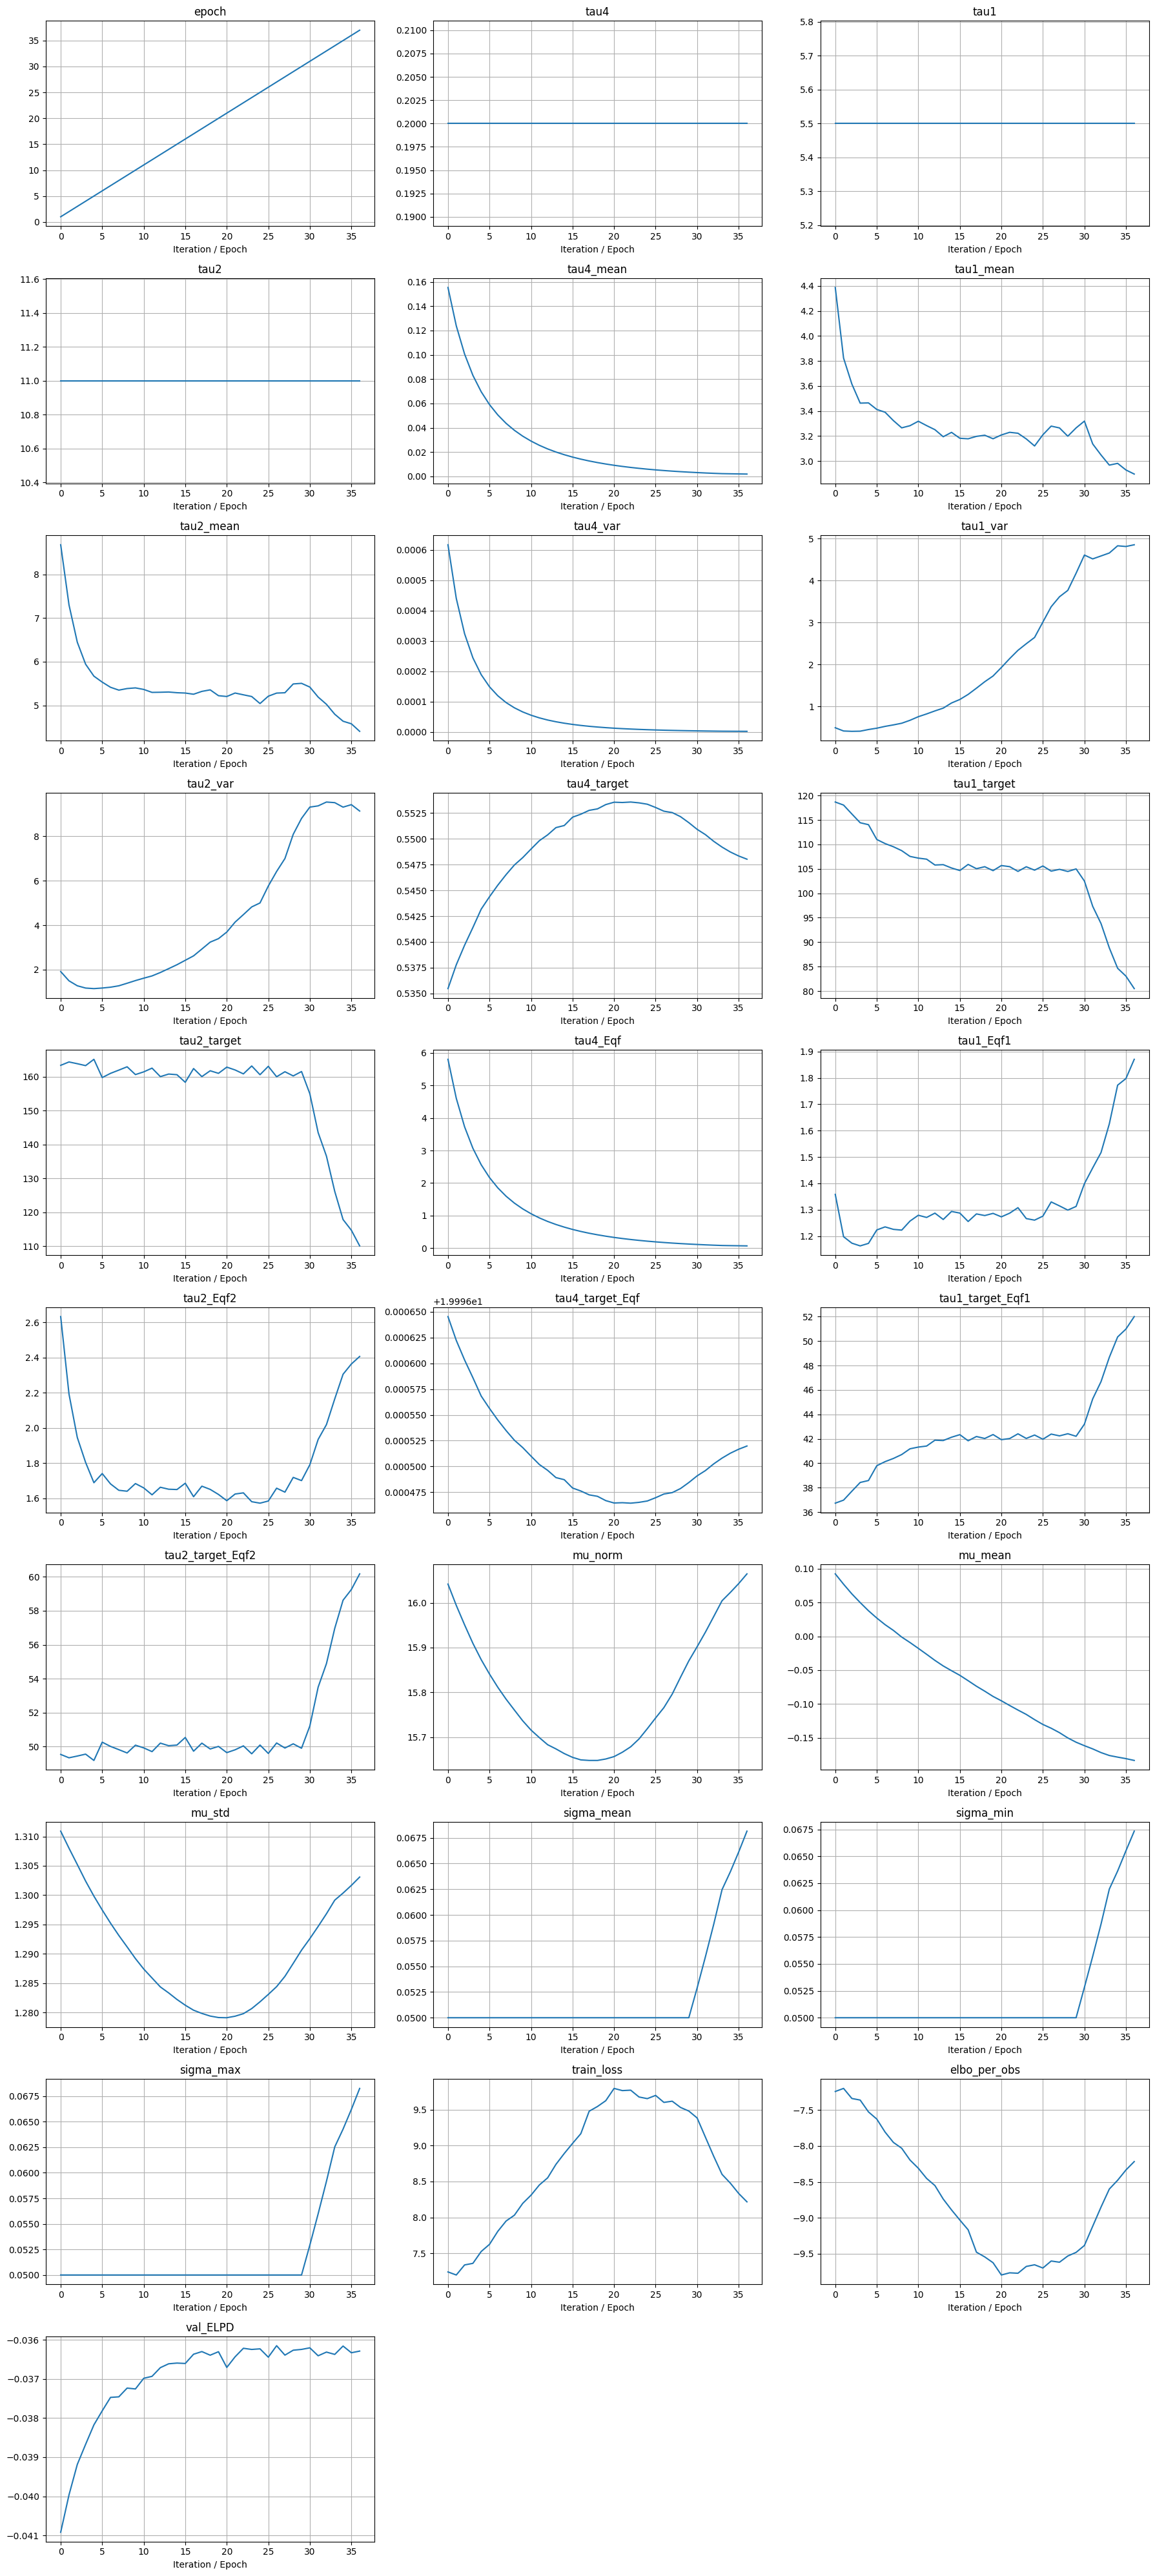

In [46]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

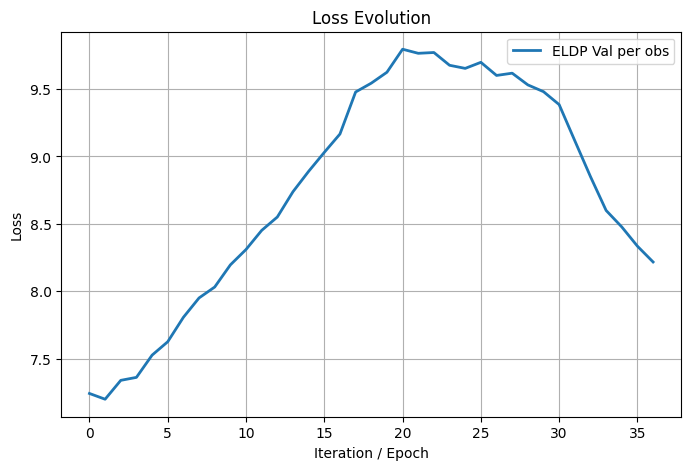

In [47]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [48]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [49]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [50]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.037
KLD GTM      Train Data:  0.1348
KLD Gaussian Train Data:  0.1219
KLD Copula   Train Data:  0.4265

KLD BGTM      Test  Data:  0.0548
KLD GTM      Test  Data:  0.148
KLD Gaussian Test  Data:  0.1208
KLD Copula   Test  Data:  0.4361


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [51]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

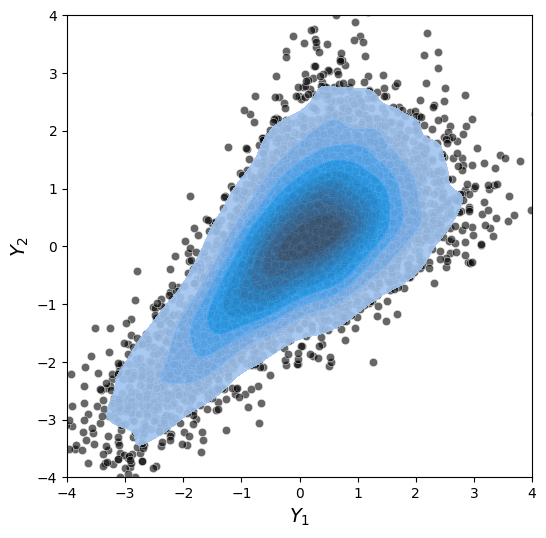

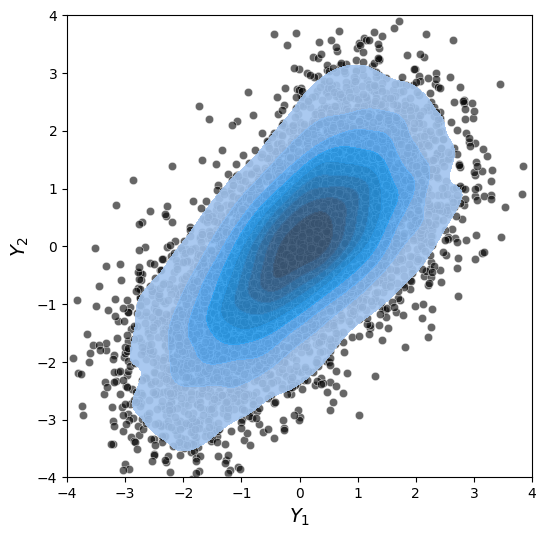

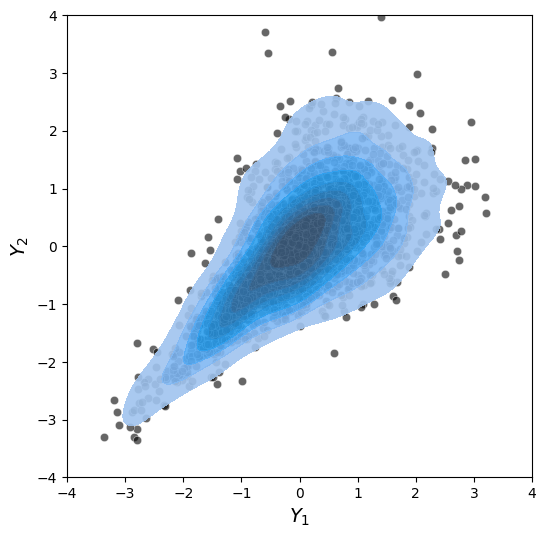

In [52]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [19]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [20]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


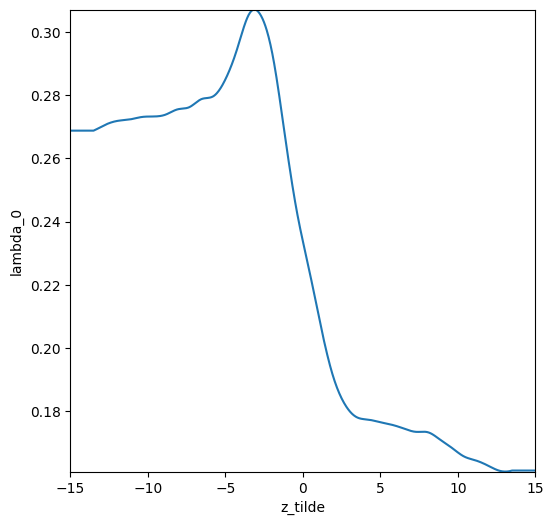

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


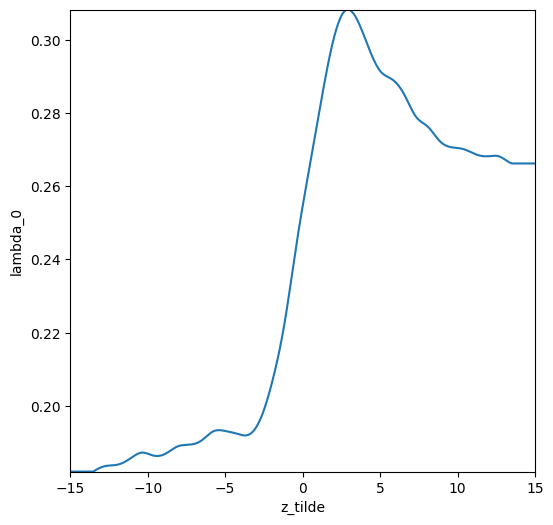

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


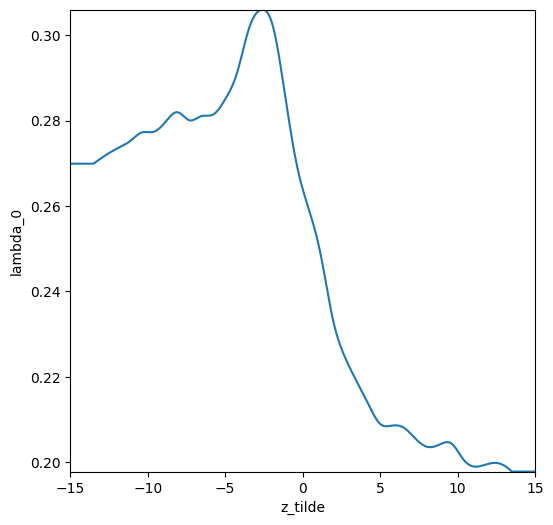

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)